## About Project

### Time-Series Forecasting Framework

This study applies a time-series machine learning approach to forecast weekly sales for Walmart stores using historical sales data. The methodology is designed to capture temporal patterns while preserving the chronological structure of the data, ensuring that future information is never used during model training or evaluation.

### Feature Engineering and Seasonality Capture

To account for seasonal and trend effects, time-based features such as year, month, and week are extracted from the date variable. These features enable the model to learn recurring patterns, including long-term trends and seasonal fluctuations in sales behavior.

### Prevention of Temporal Leakage

Temporal leakage occurs when future observations are inadvertently incorporated into the training process, leading to biased evaluation metrics and inflated predictive performance. To mitigate this risk, a store-level chronological train–test split is employed, ensuring that all test observations strictly occur after the training period.

### Model Selection and Learning Objective

Sales forecasting is performed using an XGBoost regression model, which minimizes prediction errors by measuring the deviation between predicted and actual sales values. This objective allows the model to produce more accurate and reliable forecasts.

### Handling Nonlinear Sales Patterns

Sales data often exhibit nonlinear behavior. For example, sales may increase sharply during holiday periods rather than gradually over time, and promotional discounts can generate large initial sales boosts with diminishing marginal effects at deeper discount levels. To capture these complex relationships between temporal features and sales outcomes, the model employs gradient-boosted decision trees.

### Hyperparameter Tuning and Model Complexity

Hyperparameter tuning plays a critical role in controlling model learning behavior and complexity, directly influencing underfitting, overfitting, and overall performance. In tree-based boosting models, maximum tree depth regulates how many splits a tree can make, with shallower trees (3–8 levels) reducing overfitting and deeper trees(6–12 levels) enabling the capture of more complex patterns in larger datasets.

### Boosting Strategy and Regularization

The number of boosting iterations determines how much the model learns: too few trees result in underfitting, while too many lead to overfitting. When combined with a small learning rate, the model improves gradually while maintaining generalization. Subsampling, which trains each tree on a random subset of observations (e.g., 80%), introduces randomness and reduces correlation among trees. Column sampling further enhances robustness by limiting feature dependence across trees.

### Model Evaluation and Forecasting Horizon

Model performance is evaluated using data not seen during training to ensure unbiased assessment. A recursive multi-step forecasting procedure is applied to generate sequential predictions for multiple future periods, such as the next 12 weeks.

### Prediction Intervals and Visualization

Based on historical forecast errors, a 95% prediction interval is constructed, indicating that the true sales values are expected to fall within this range with 95% confidence. The resulting forecasts and confidence intervals are analyzed and visualized to assess store-level sales trends and the variability of projected outcomes.


## Mount Google Drive & Import Libraries

Mounts Google Drive, uses libraries for data handling, modeling, and plotting, and hides unnecessary warnings.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
from datetime import timedelta

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Data Science and ML/Walmart/Walmart.csv')



In [5]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


## Feature engineering

Converts the "Date" column to a proper datetime type, which allows extracting year, month, week, etc.

Sorts data by Store and Date so that time series operations like lagging work correctly.

In [6]:
df["Date"] = pd.to_datetime(df["Date"], format="mixed", dayfirst=True)

In [7]:
df["Date"] = pd.to_datetime(df["Date"])

In [8]:
df = df.sort_values(["Store","Date"])

**Calender Features**

Extracts time-related features: year, month, week, weekday

These can help models detect seasonality trends, like higher sales in December or weekends.

In [9]:
# Calendar features
df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month
df["week"] = df["Date"].dt.isocalendar().week.astype(int)
df["weekday"] = df["Date"].dt.weekday

**Lag Features**

Lag features are previous weeks’ sales values for the same store.

Example: lag_1 is last week’s sales, lag_52 is the sales one year ago.

Helps the model learn trends and patterns over time.

In [10]:
# Lag features
for l in [1,2,3,4,12,52]:
    df[f"lag_{l}"] = df.groupby("Store")["Weekly_Sales"].shift(l)

**Rolling Features**

roll_4 - 4-week rolling average of past sales.

roll_8 - 8-week rolling average of past sales.

shift(1) ensures we don’t include current week’s sales (avoiding “data leakage”).

df.dropna() - Removes rows with missing values (because lag/rolling creates NaNs at the start).

In [11]:
# Rolling
df["roll_4"] = df.groupby("Store")["Weekly_Sales"].shift(1).rolling(4).mean()
df["roll_8"] = df.groupby("Store")["Weekly_Sales"].shift(1).rolling(8).mean()

df = df.dropna()

## Train / Test split

Splits the data into training (before 2012) and testing (2012 and after).

Time-based split is important for time series forecasting.

In [12]:
train = df[df["Date"] < "2012-01-01"]
test  = df[df["Date"] >= "2012-01-01"]

**Feature and Target Selection**

features → Columns used as inputs for the model.

y_train = np.log1p(...) → Uses log transformation to stabilize variance (sales are skewed).

X_train & X_test → Input features for model training/testing.

In [13]:
features = [
 "Store","Holiday_Flag","Temperature","Fuel_Price","CPI","Unemployment",
 "year","month","week","weekday",
 "lag_1","lag_2","lag_3","lag_4","lag_12","lag_52","roll_4","roll_8"
]

X_train = train[features]
y_train = np.log1p(train["Weekly_Sales"])
X_test  = test[features]
y_test  = test["Weekly_Sales"]

## Train model

Uses XGBoost, a powerful tree-based model for regression.

Hyperparameters: n_estimators=500 - 500 trees, max_depth=6 - Trees aren’t too deep (avoid overfitting), learning_rate=0.05 - Small steps for boosting, subsample & colsample_bytree - Random sampling for robustness.

Trains the model on X_train and y_train.

**Model**

XGBRegressor is an implementation of Gradient Boosting for regression tasks.

It builds an ensemble of decision trees, where each new tree tries to correct the errors of the previous ones.

It supports regularization, which reduces overfitting.

Fast, robust, and works well on tabular datasets.

**Why XGBoost was chosen for this task**

**Handles Time Series Features Well**

*   This model created lag features (lag_1, lag_2, …) and rolling averages (roll_4, roll_8).
*   Gradient boosting models like XGBoost are excellent at learning complex relationships from these engineered features.

**Non-linear Relationships**

*   Sales data is often non-linear, affected by seasonality, holidays, and economic indicators.
*   XGBoost can automatically capture non-linear patterns without explicit modeling.

**Works with Missing Values & Outliers**

*   Real-world datasets often have missing values or irregular patterns.
*   XGBoost can handle these more gracefully than linear regression.

**High Accuracy**

Gradient boosting is known to perform very well on tabular regression tasks, often outperforming simpler models like linear regression or decision trees alone.

**Flexibility for Forecasting**

Although you are doing recursive multi-step forecasts, XGBoost can predict one step ahead at a time using your lagged features, making it suitable for this approach.

In [14]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror"
)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

## Accuracy

Predicts sales on the test set and converts back from log scale using expm1.

Calculates MAPE (Mean Absolute Percentage Error) → % error in predictions.

In [15]:
from sklearn.metrics import mean_absolute_percentage_error

pred_test = np.expm1(model.predict(X_test))
print("MAPE:", mean_absolute_percentage_error(y_test, pred_test))


MAPE: 0.05188769165678436


## Recursive 12-week forecast per store

Generates the next 12 weeks for forecasting.

For each store:

*   Take historical data.
*   Predict sales week by week using previous weeks (recursive forecast).
*   Add predicted week to history for next prediction.

**Interpretation:**

For each store, you forecasted sales for the next 12 weeks, using:
*   Last known values for external variables (temperature, CPI, etc.)
*   Lagged sales and rolling averages to capture patterns.

Recursive prediction: Each week’s forecast feeds into the next week’s prediction.

This is useful for planning inventory and promotions for upcoming weeks.

In [16]:
future_dates = pd.date_range(df["Date"].max()+pd.Timedelta(weeks=1), periods=12, freq="W")

def forecast_store(store):
    hist = df[df["Store"]==store].copy()
    preds = []

    for d in future_dates:
        row = {
            "Store":store,
            "year":d.year,
            "month":d.month,
            "week":d.isocalendar().week,
            "weekday":d.weekday()
        }

        for c in ["Holiday_Flag","Temperature","Fuel_Price","CPI","Unemployment"]:
            row[c] = hist[c].iloc[-1]

        for l in [1,2,3,4,12,52]:
            row[f"lag_{l}"] = hist["Weekly_Sales"].iloc[-l]

        row["roll_4"] = hist["Weekly_Sales"].iloc[-4:].mean()
        row["roll_8"] = hist["Weekly_Sales"].iloc[-8:].mean()

        X = pd.DataFrame([row])[features]
        pred = np.expm1(model.predict(X))[0]

        row["Date"] = d
        row["Forecast"] = pred
        preds.append(row)

        hist = pd.concat([hist, pd.DataFrame([{"Date":d,"Store":store,"Weekly_Sales":pred}])])

    return pd.DataFrame(preds)


## All stores

Combines forecasts for all stores into a single DataFrame.

In [17]:
forecast_df = pd.concat([forecast_store(s) for s in df["Store"].unique()])


## Confidence bands

Calculates 95% confidence intervals for forecast:

*   z = 1.96 - 95% confidence.
*   Risk - Width of the interval; higher width = more uncertainty.

**Interpretation:**

You calculated a 95% confidence interval using the test set errors.

It shows a range where the actual sales are likely to fall. Wider bands → more uncertainty.

In [18]:
errors = y_test - pred_test
sigma = errors.std()
z = 1.96

forecast_df["Lower"] = forecast_df["Forecast"] - z*sigma
forecast_df["Upper"] = forecast_df["Forecast"] + z*sigma
forecast_df["Risk"] = forecast_df["Upper"] - forecast_df["Lower"]


## Risky stores

### Auto-assign numeric bins

Computes the average risk for each store.

Categorizes stores into low/medium/high risk based on their average risk.

Sorts stores from highest to lowest risk.

In [19]:
store_risk = forecast_df.groupby("Store")["Risk"].mean().reset_index()

# No labels, just categories
store_risk["Risk_Level"] = pd.qcut(
    store_risk["Risk"],
    q=3,
    duplicates="drop"
)

store_risk = store_risk.sort_values("Risk", ascending=False)


### Dynamically adjust labels

Computes the average risk per store.

Splits stores into 3 risk levels (tertiles) based on their average risk.

Assigns custom labels like "Level 1", "Level 2", "Level 3" to make it more readable.

duplicates="drop" handles any overlapping bins.

So after this, store_risk has three columns: Store, Risk and Risk_level

In [20]:
store_risk = forecast_df.groupby("Store")["Risk"].mean().reset_index()

# Create bins
bins = pd.qcut(store_risk["Risk"], q=3, duplicates="drop")

# Create labels matching the actual number of bins
labels = [f"Level {i+1}" for i in range(bins.cat.categories.size)]

# Assign Risk_Level
store_risk["Risk_Level"] = pd.qcut(store_risk["Risk"], q=3, labels=labels, duplicates="drop")


### Use fixed quantiles (most robust for dashboards)

This code manually splits stores into 3 risk levels based on the 33rd and 66th percentiles of risk:

Risk value is ≤ 33rd percentile   - Risk level is low

Risk value is > 33rd percentile   - Risk level is medium

Risk value is > 66th percentile   - Risk level is high

This achieves the same end as qcut, but you have full control over the cut points and labels.

In [21]:
store_risk = forecast_df.groupby("Store")["Risk"].mean().reset_index()

p33 = store_risk["Risk"].quantile(0.33)
p66 = store_risk["Risk"].quantile(0.66)

store_risk["Risk_Level"] = np.where(
    store_risk["Risk"] <= p33, "Low",
    np.where(store_risk["Risk"] <= p66, "Medium", "High")
)


**Risk Estimation**

Calculated Risk as the width of the confidence interval for each store.

Categorized stores into Low, Medium, High Risk based on variability.

**Interpretation:**

Stores with high forecast uncertainty (high Risk) might need extra attention in inventory or staffing.

## Historical Sales, 12-Week Forecast, and 95% Confidence Interval

It gives a combined view of past sales, predicted sales, and forecast uncertainty for a specific store in a clean, easy-to-read chart.

In [22]:
def plot_store_forecast(store_id, history_df=df, forecast_df=forecast_df, last_n_weeks=100):
    """
    Plots historical sales + 12-week forecast + 95% confidence interval for a given store.

    store_id : int
        Store number to plot
    history_df : DataFrame
        Historical sales data (must contain Date, Store, Weekly_Sales)
    forecast_df : DataFrame
        Forecasted sales (must contain Date, Store, Forecast, Lower, Upper)
    last_n_weeks : int
        Number of past weeks to show
    """
    # Historical data
    hist = history_df[history_df["Store"]==store_id].tail(last_n_weeks)

    # Forecast data
    fut = forecast_df[forecast_df["Store"]==store_id]

    plt.figure(figsize=(12,6))

    # Plot historical sales
    plt.plot(hist["Date"], hist["Weekly_Sales"], label="Historical Sales", color="blue")

    # Plot forecasted sales
    plt.plot(fut["Date"], fut["Forecast"], marker="o", label="Forecasted Sales", color="orange")

    # Plot confidence interval
    plt.fill_between(fut["Date"], fut["Lower"], fut["Upper"], color="orange", alpha=0.2, label="95% CI")

    plt.title(f"Store {store_id} — Sales Forecast")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Sales Forecast Visualization for All Stores

This code loops through all stores in the dataset and generates a sales forecast plot for each one using the plot_store_forecast function.

existing_stores = df['Store'].unique() - gets all unique store IDs.

for store in sorted(existing_stores) - iterates over stores in ascending order.

plot_store_forecast(store_id=store) - plots historical sales, 12-week forecast, and 95% confidence interval for each store.

Effect: You get a separate plot for every store showing its past sales trends and future predictions.

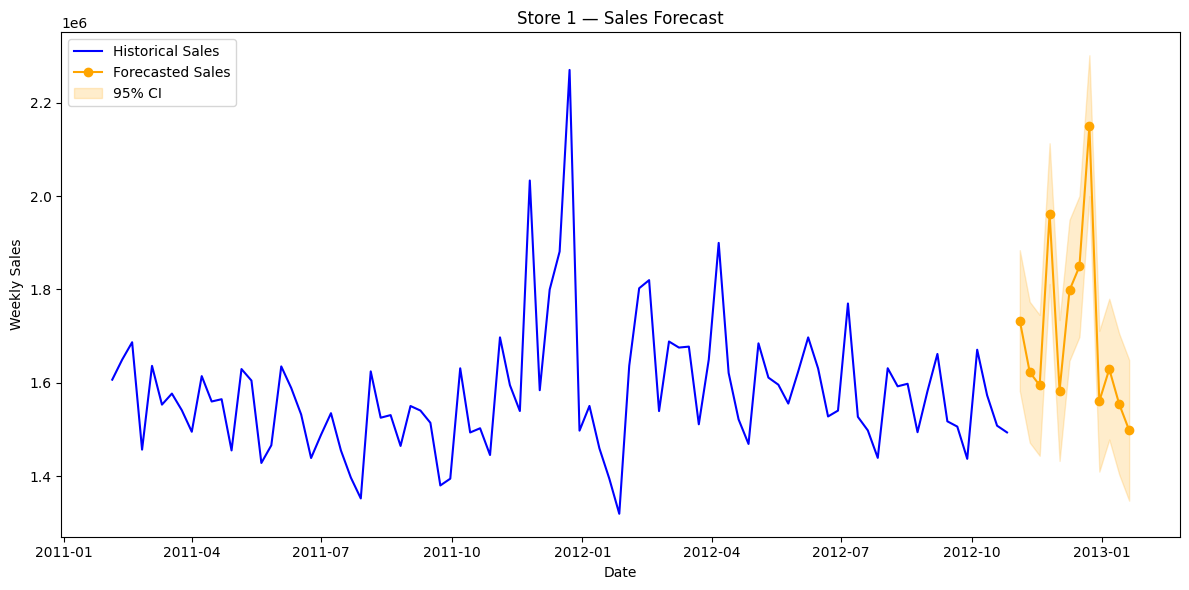

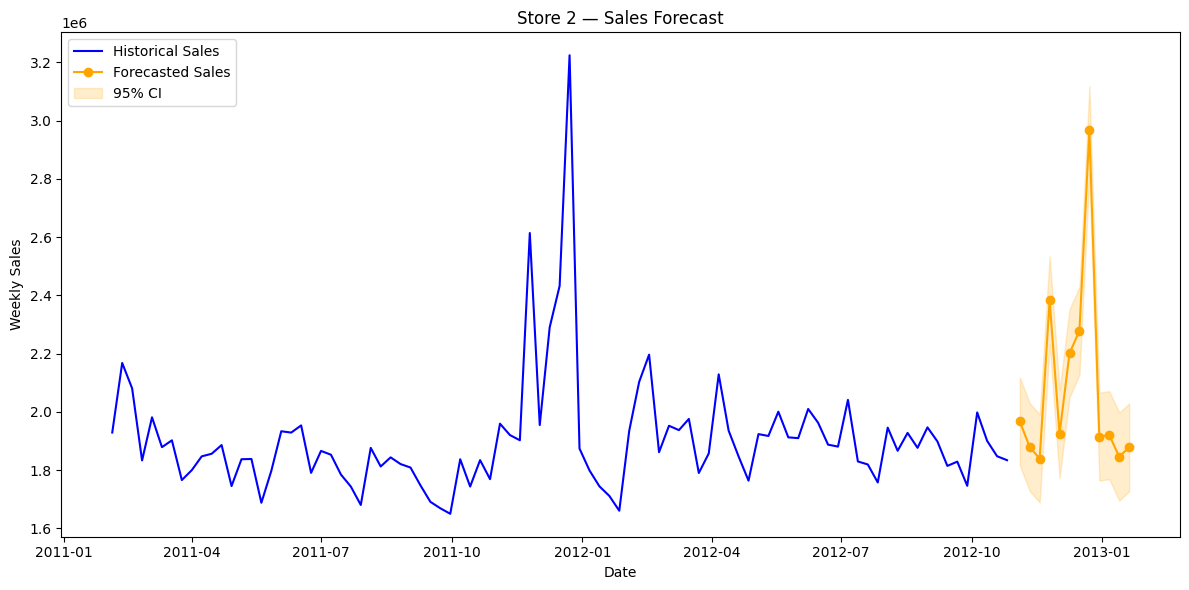

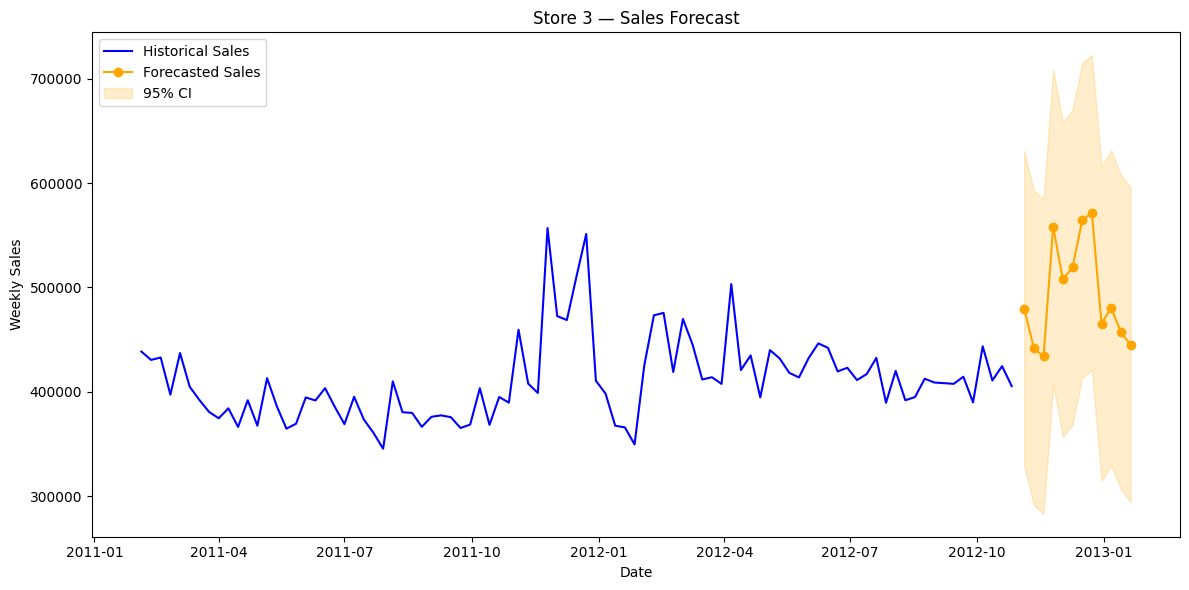

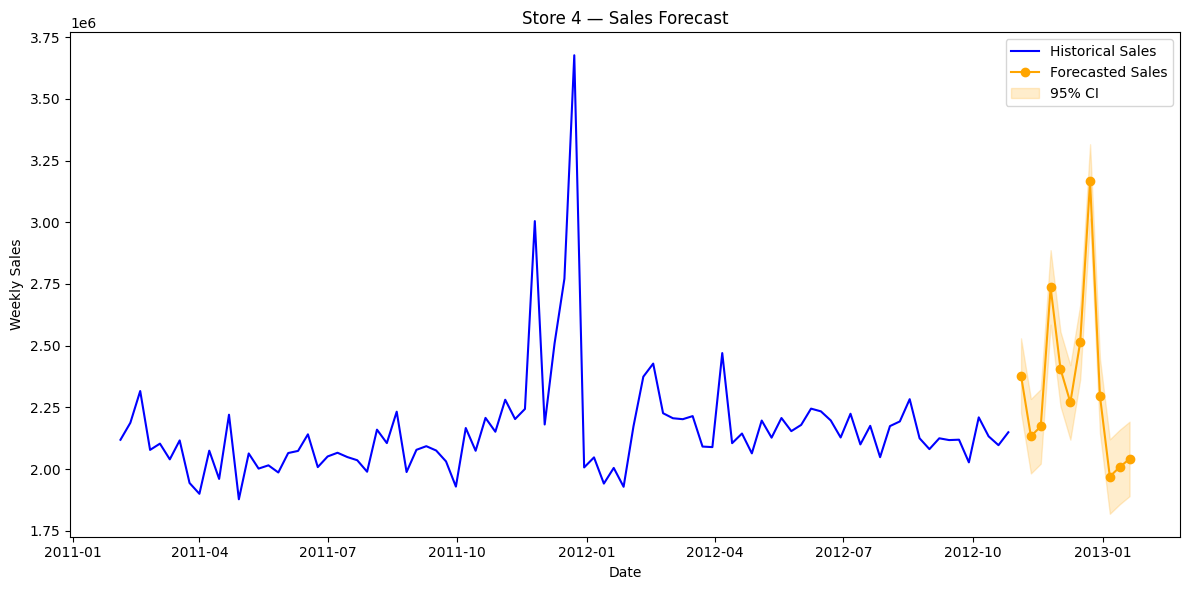

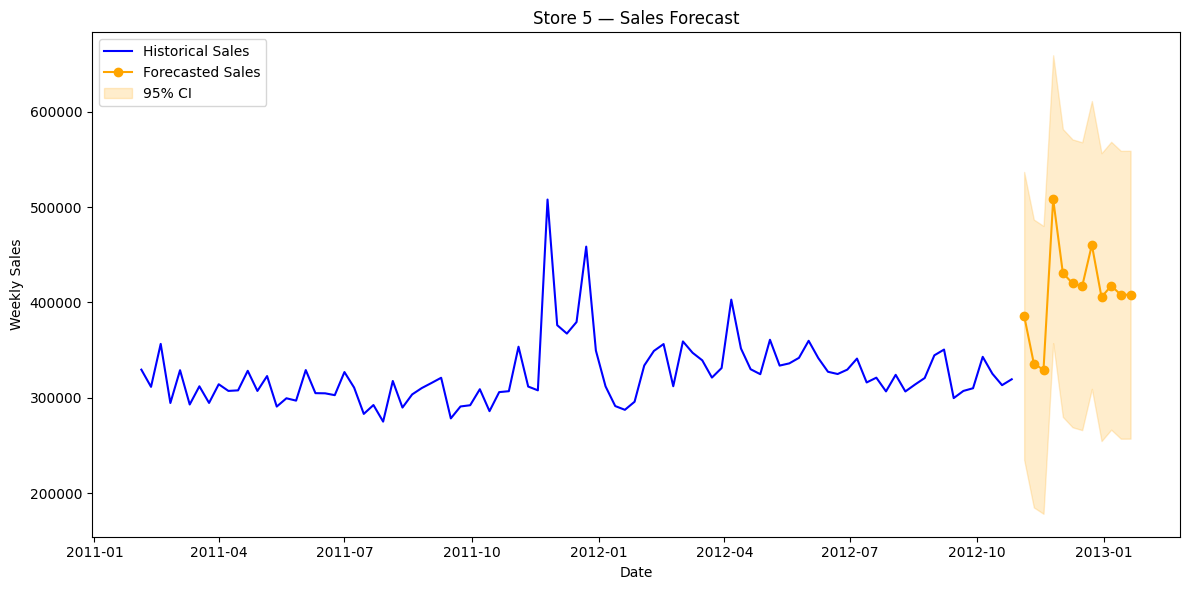

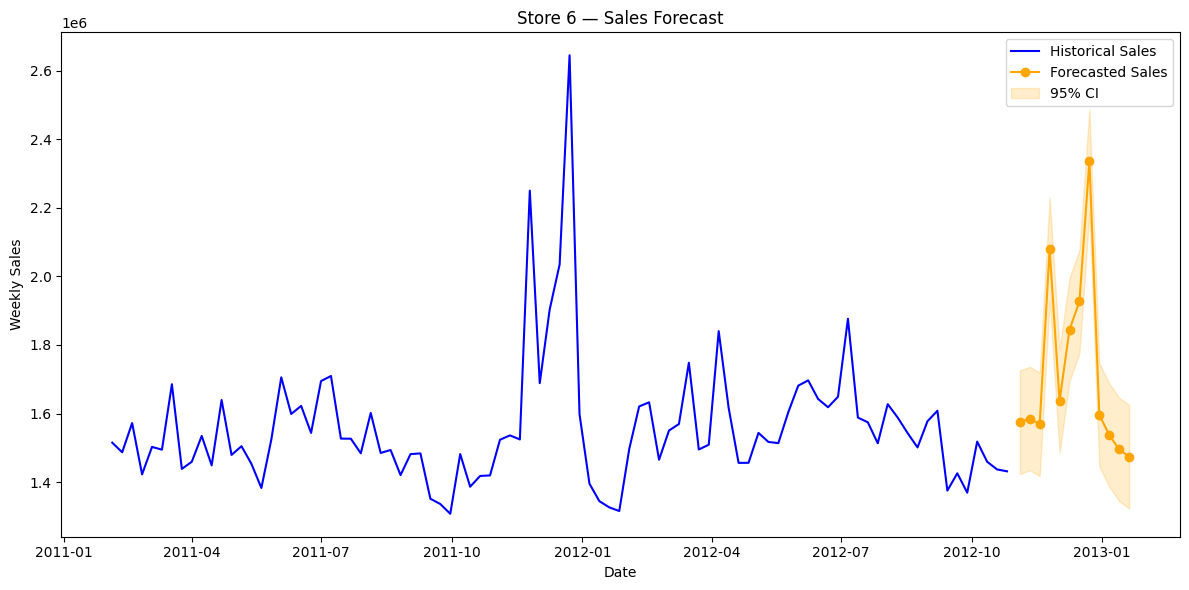

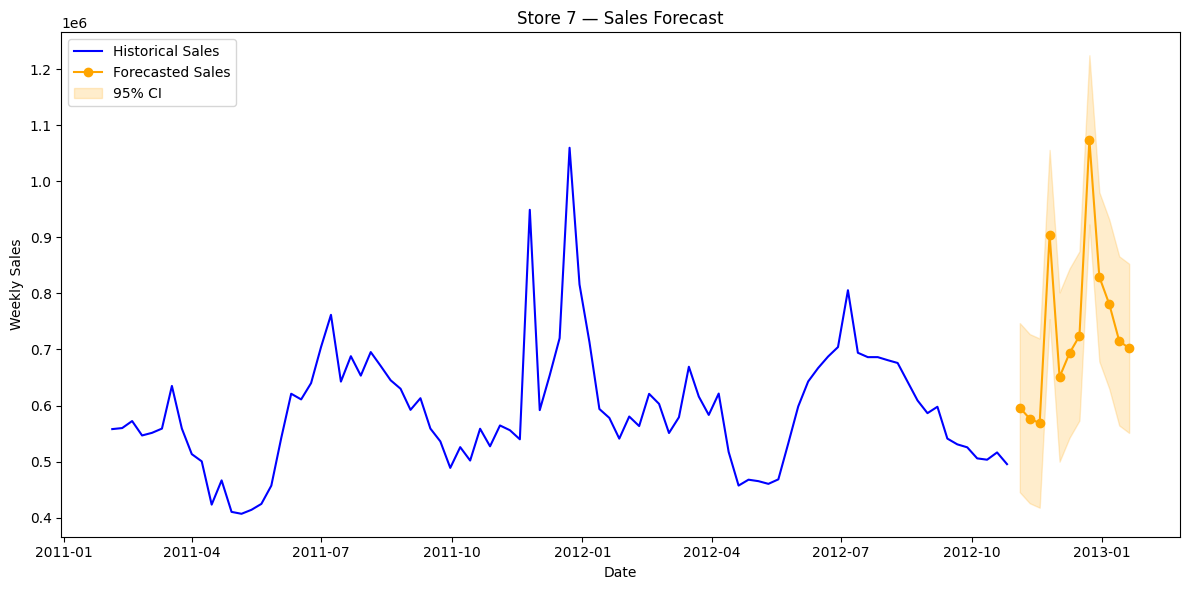

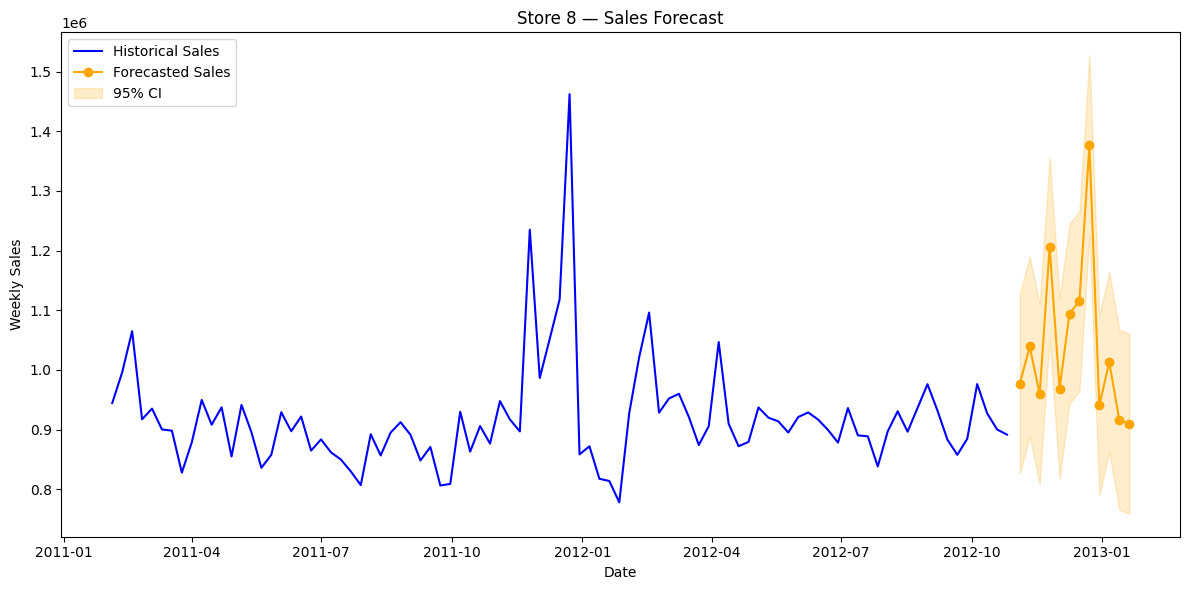

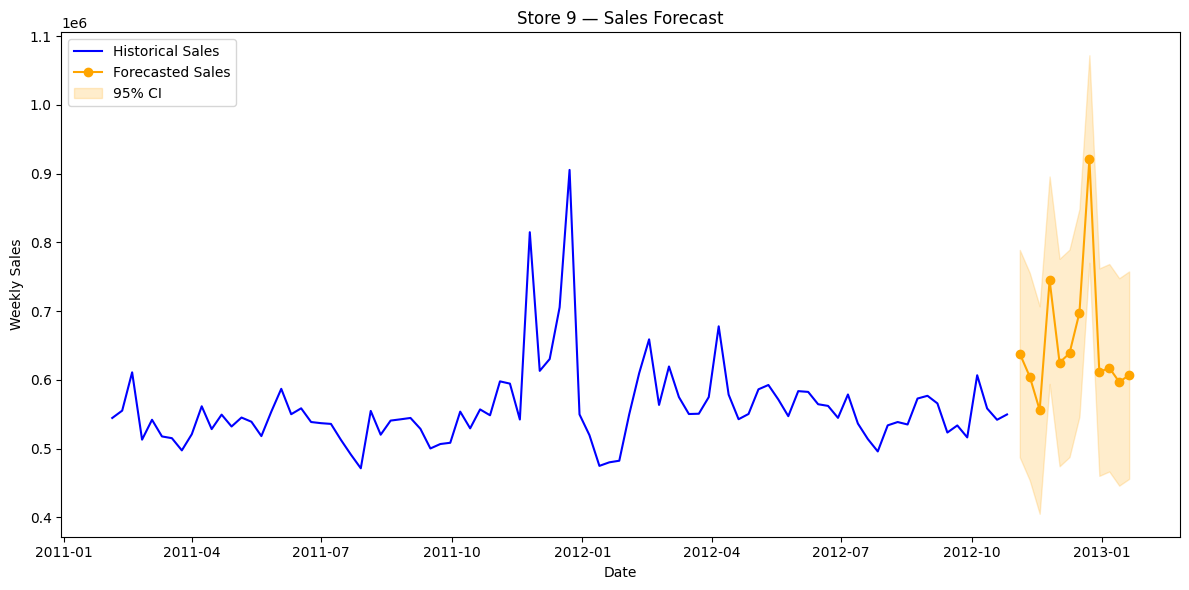

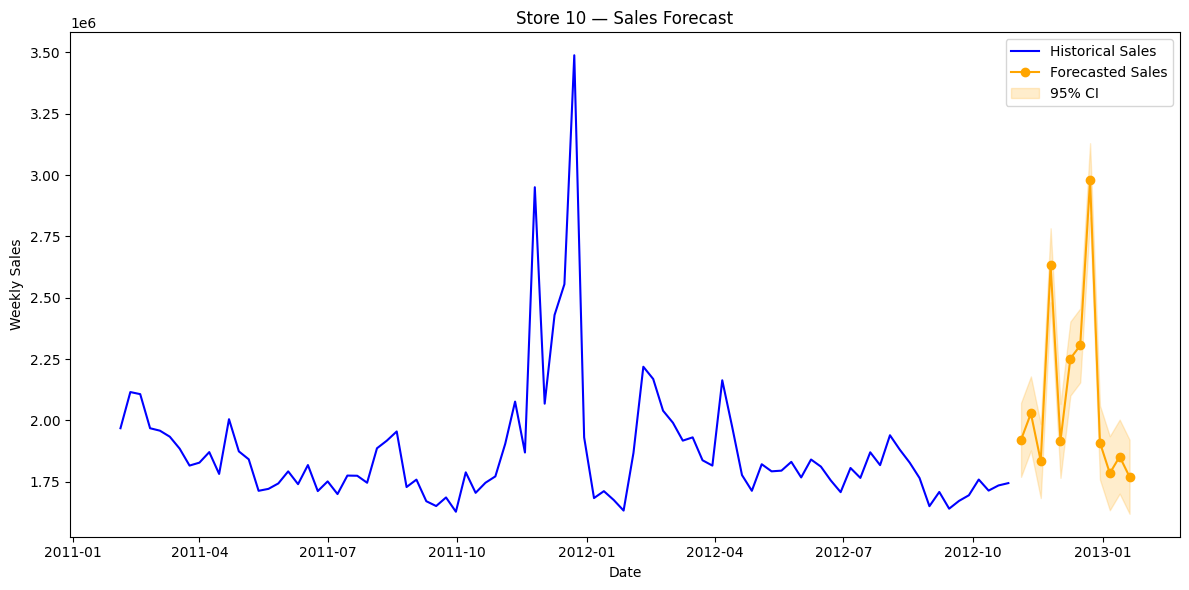

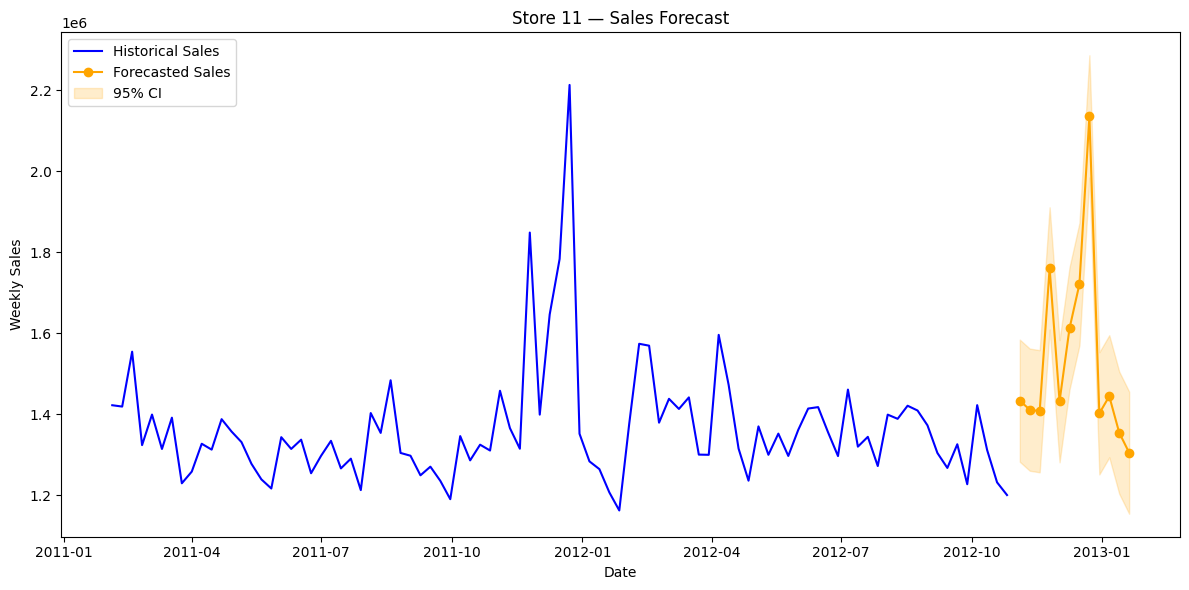

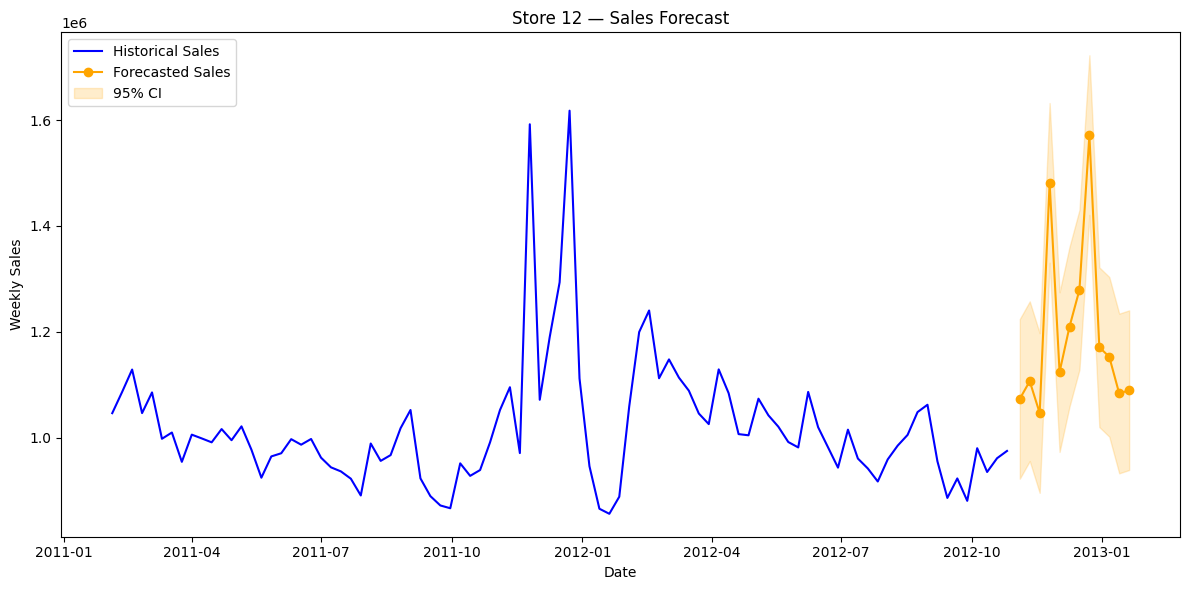

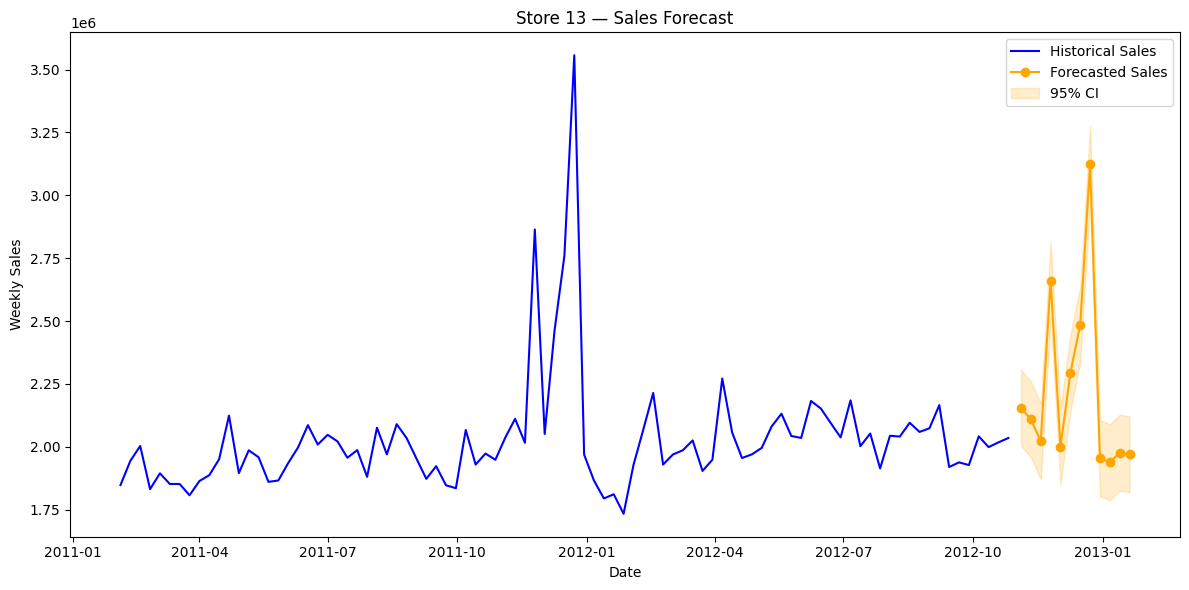

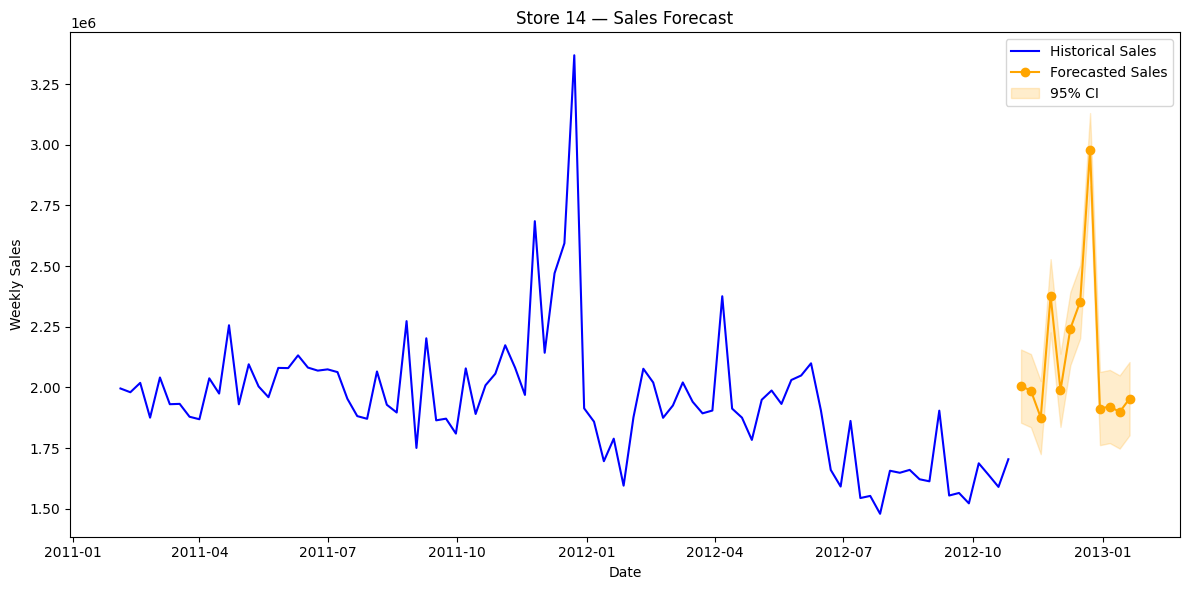

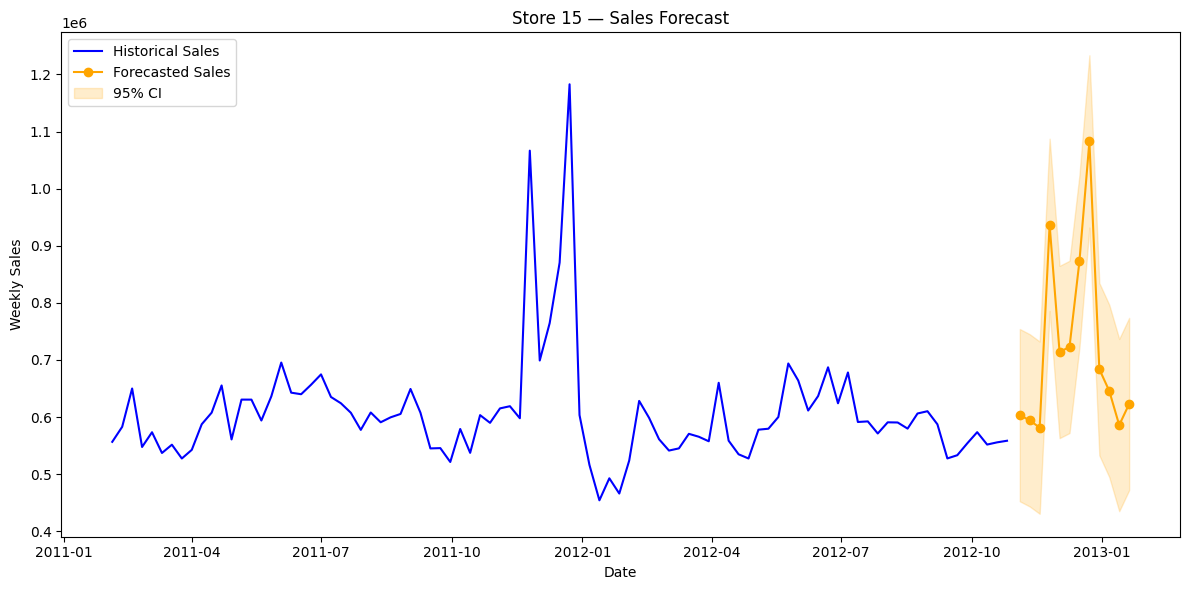

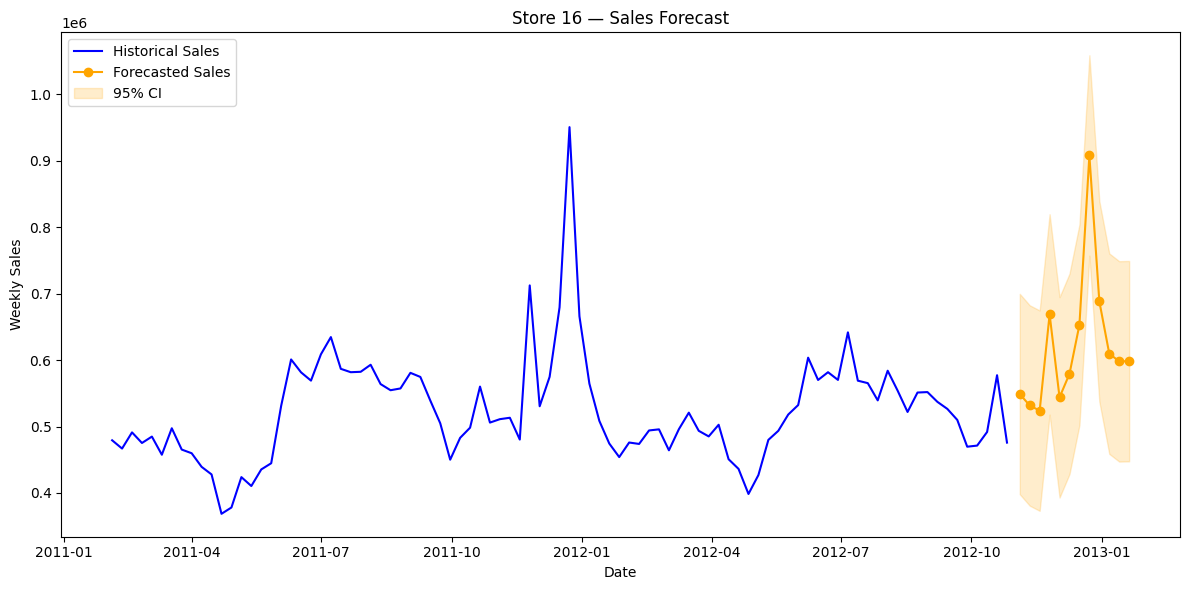

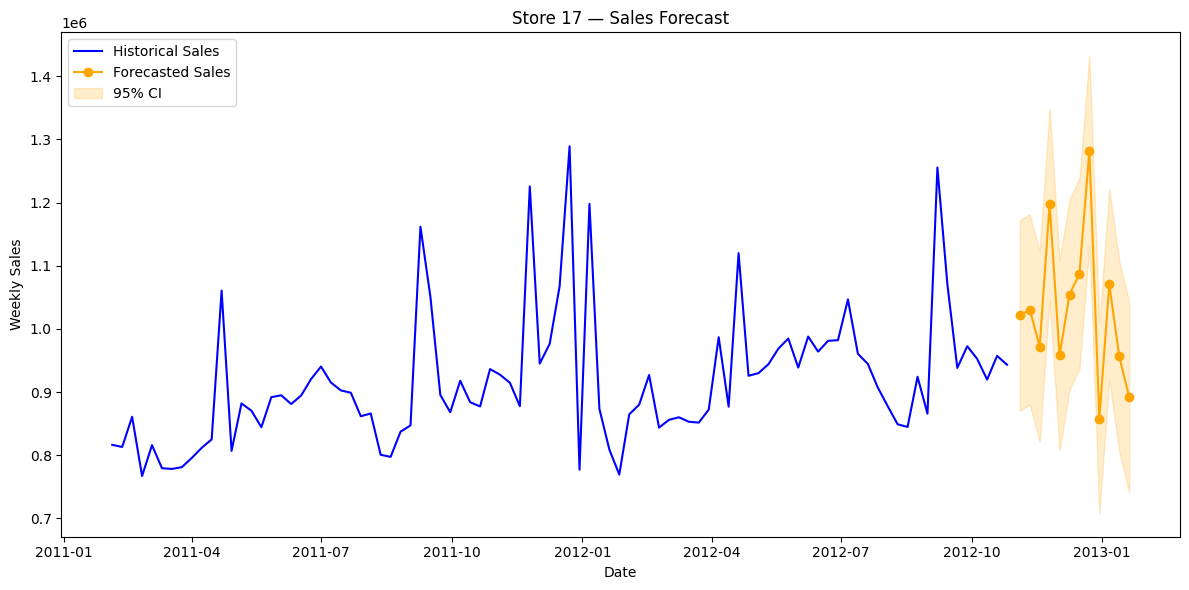

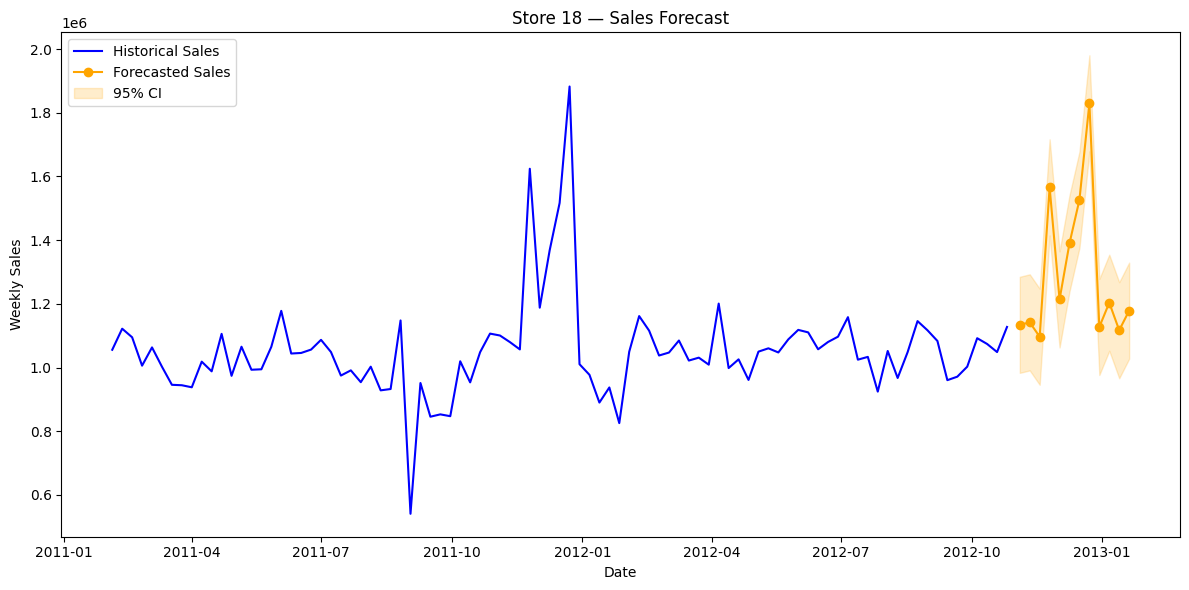

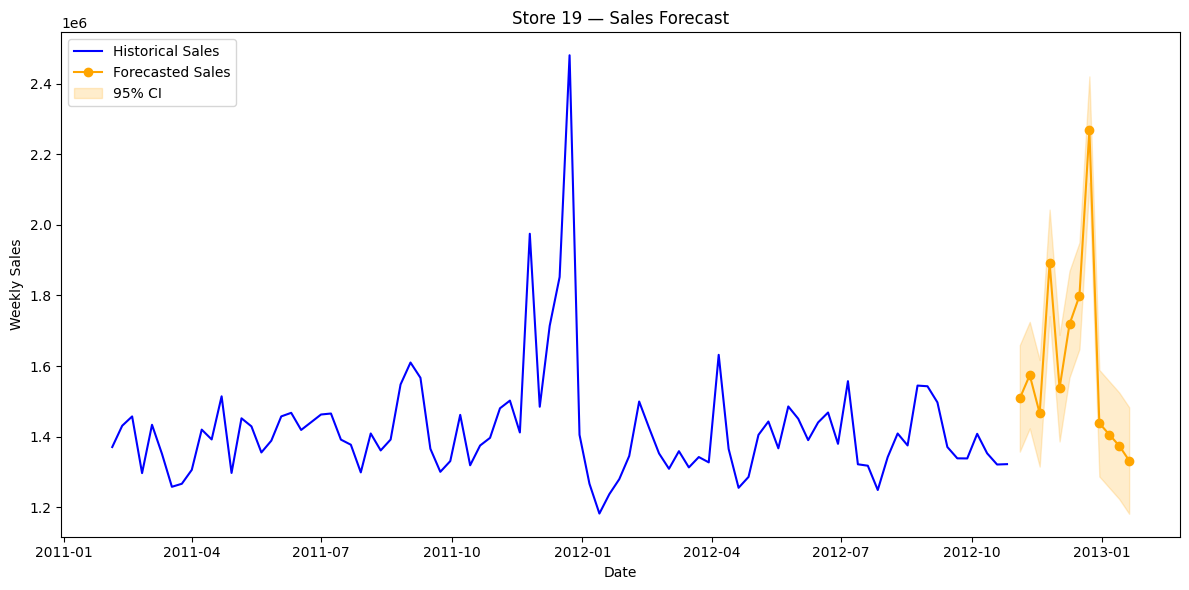

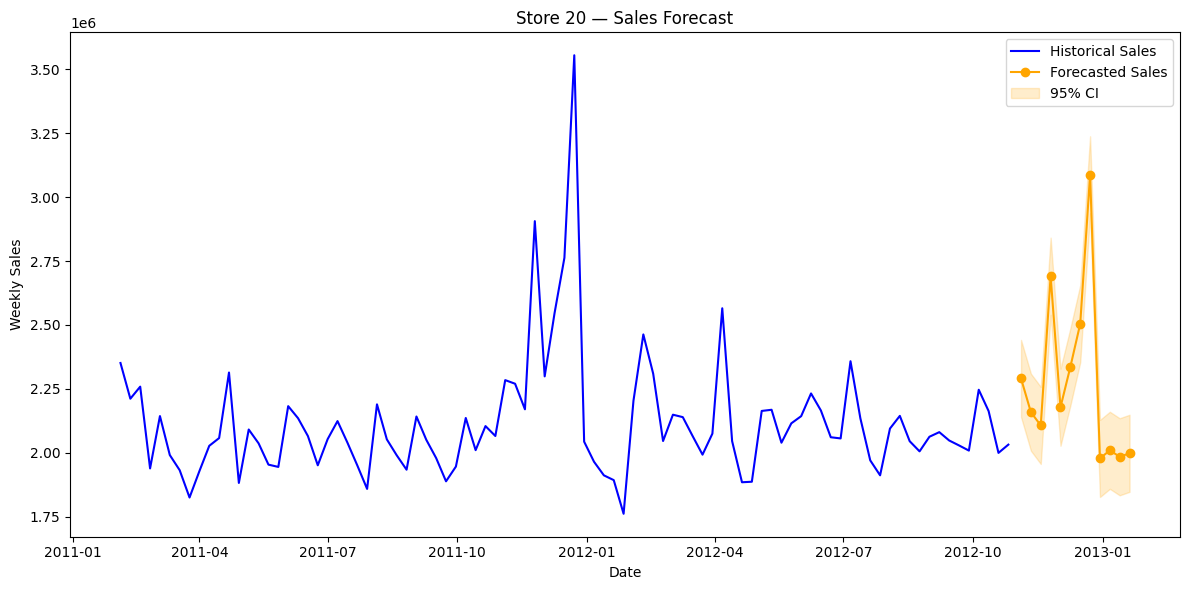

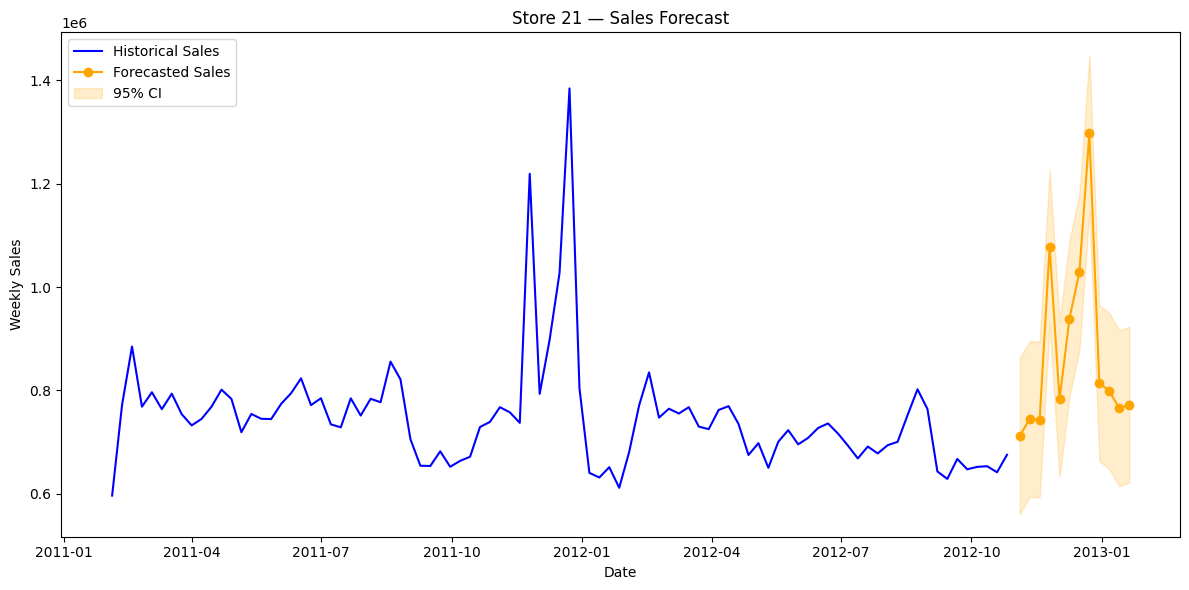

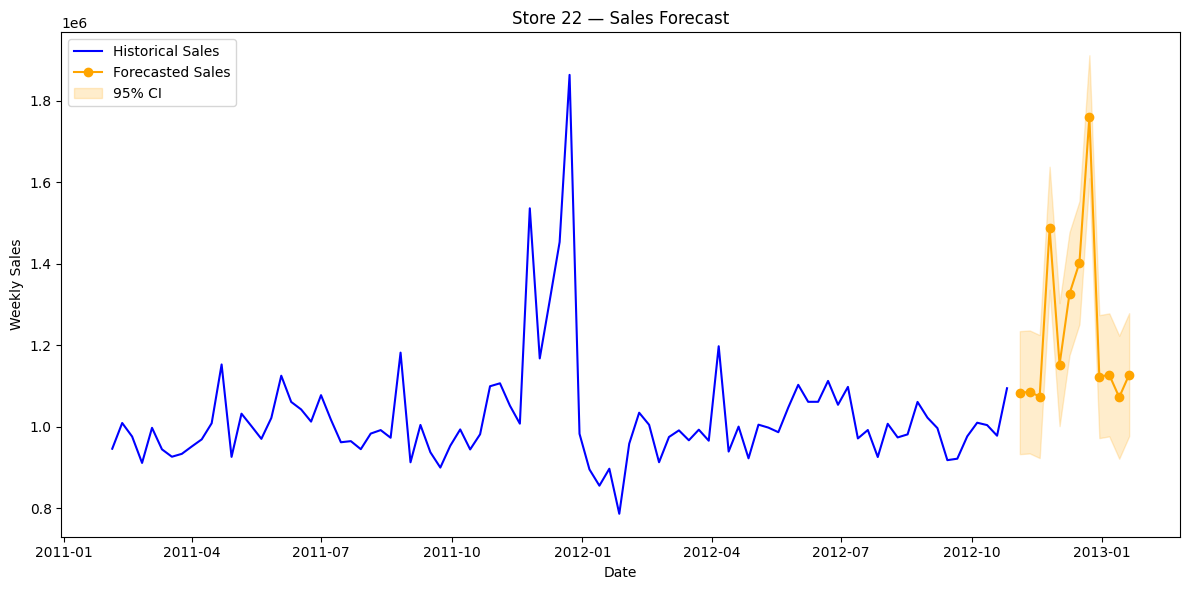

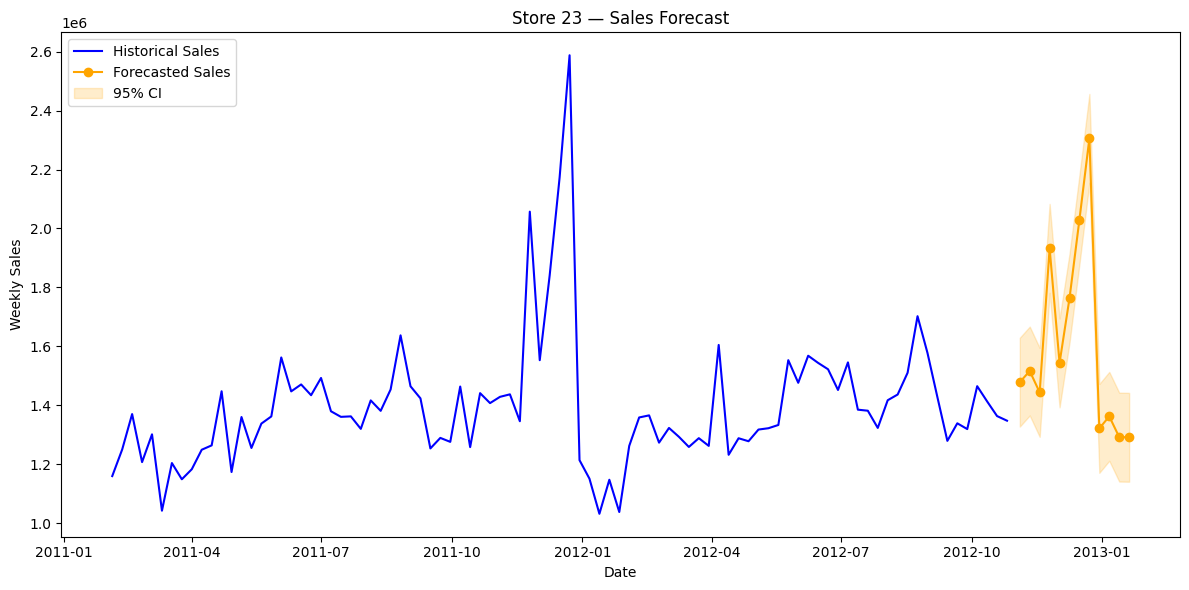

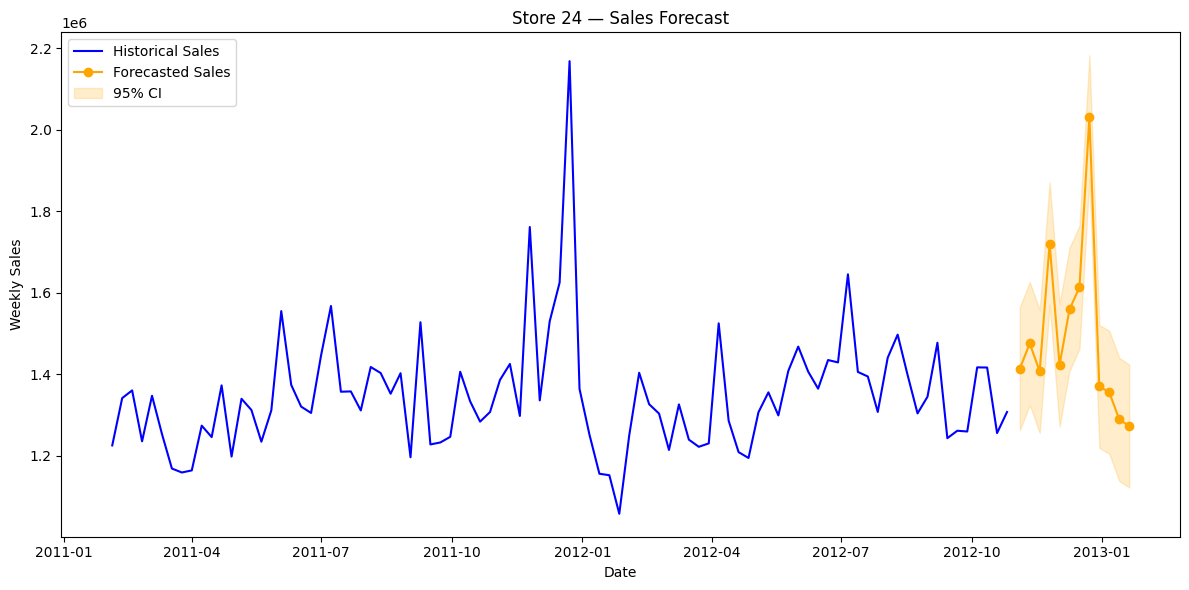

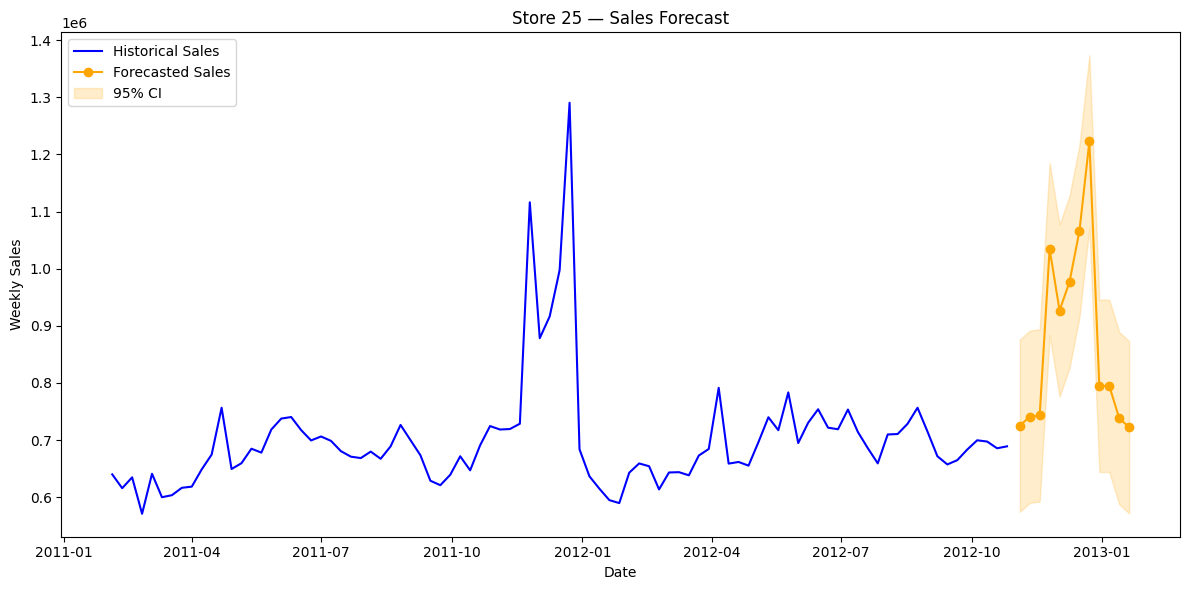

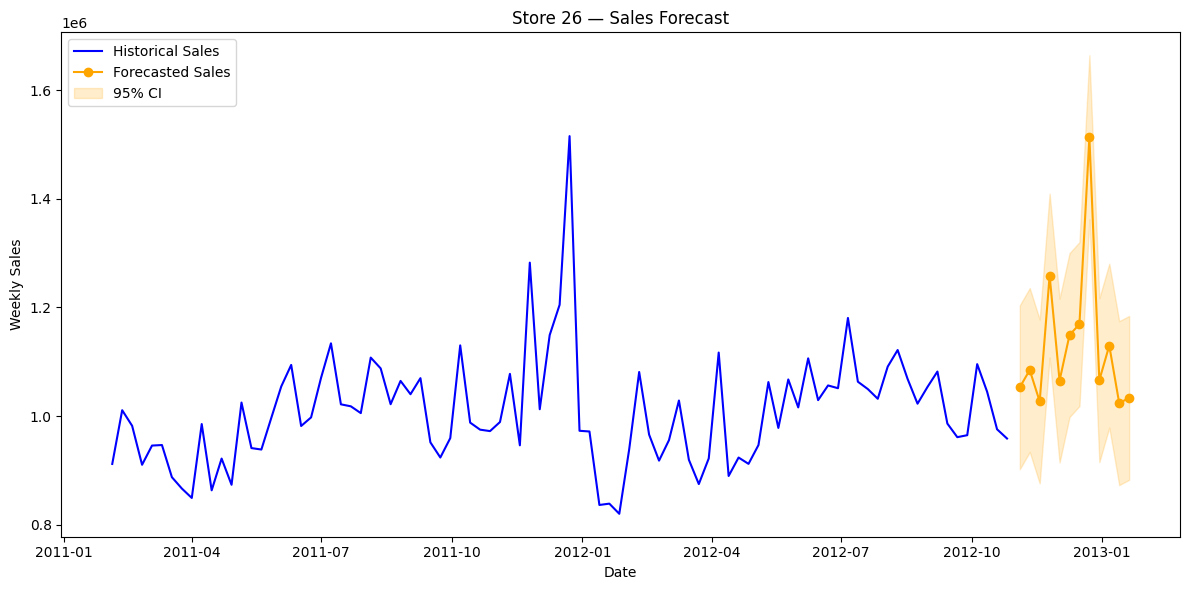

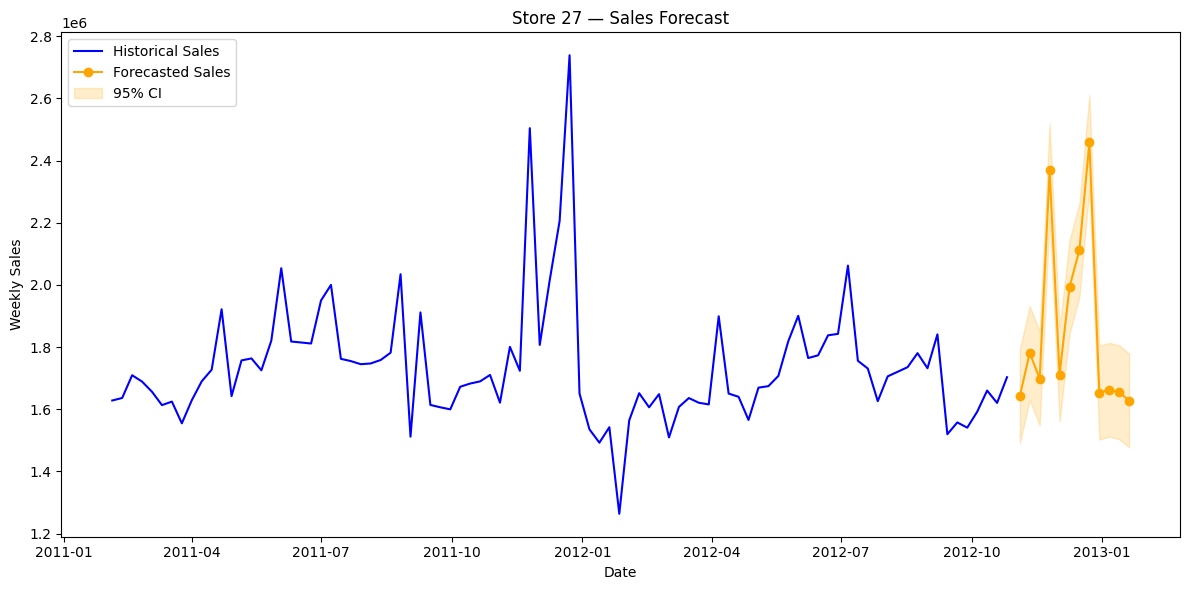

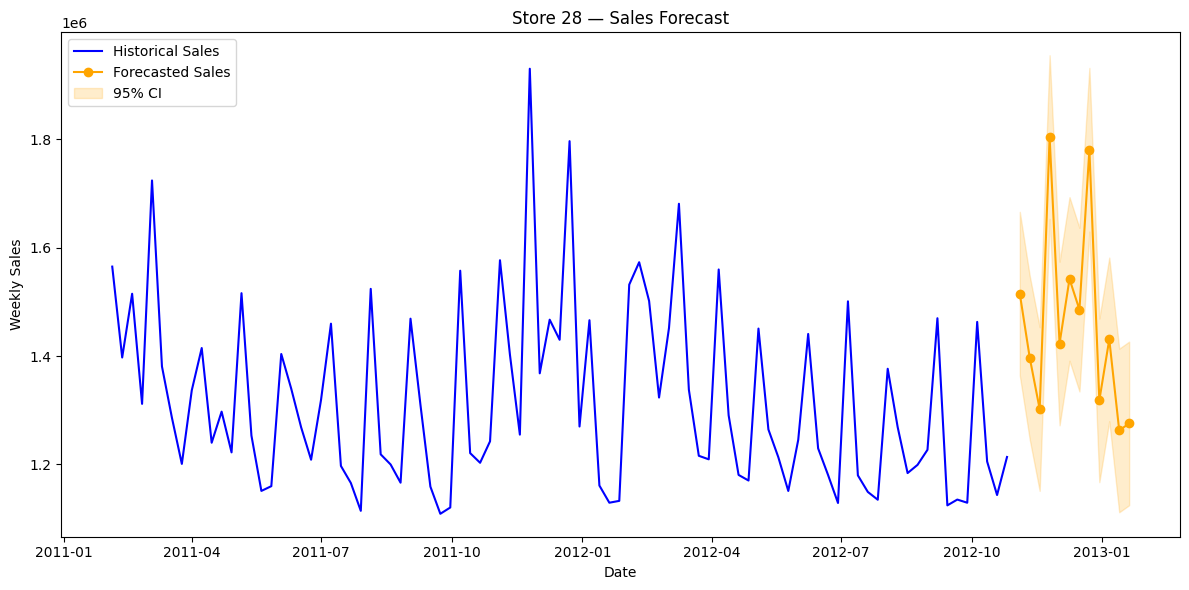

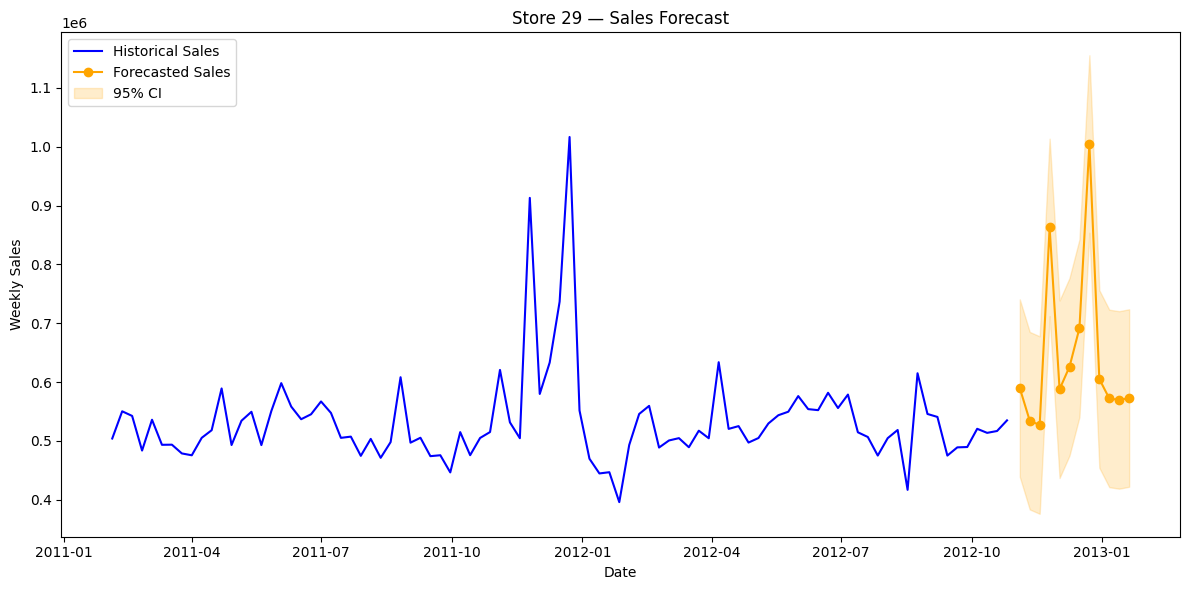

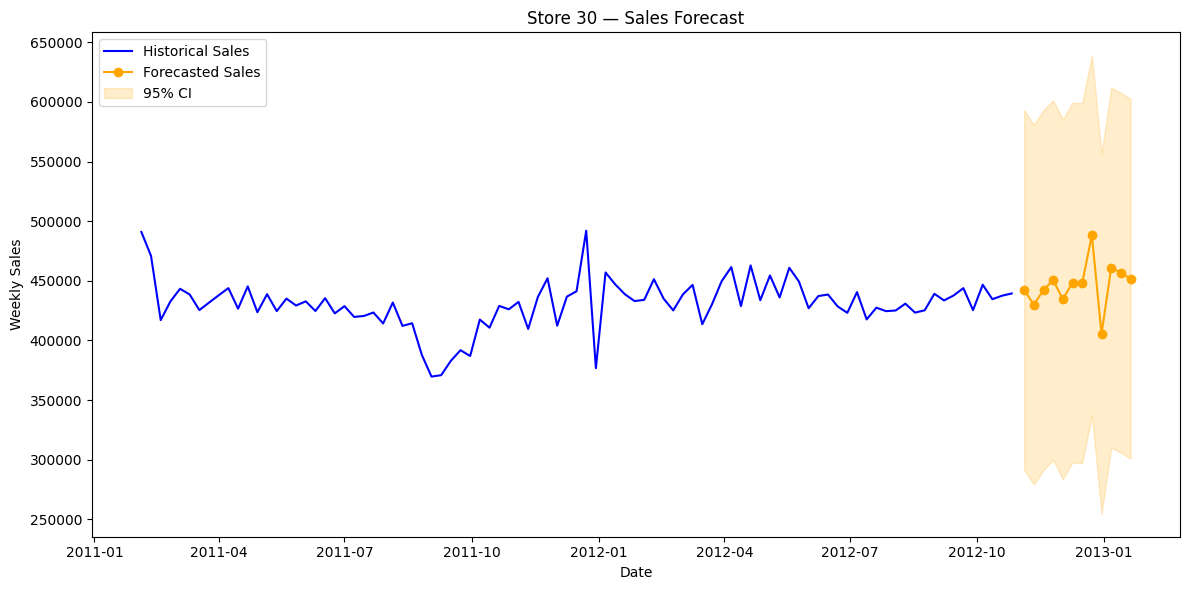

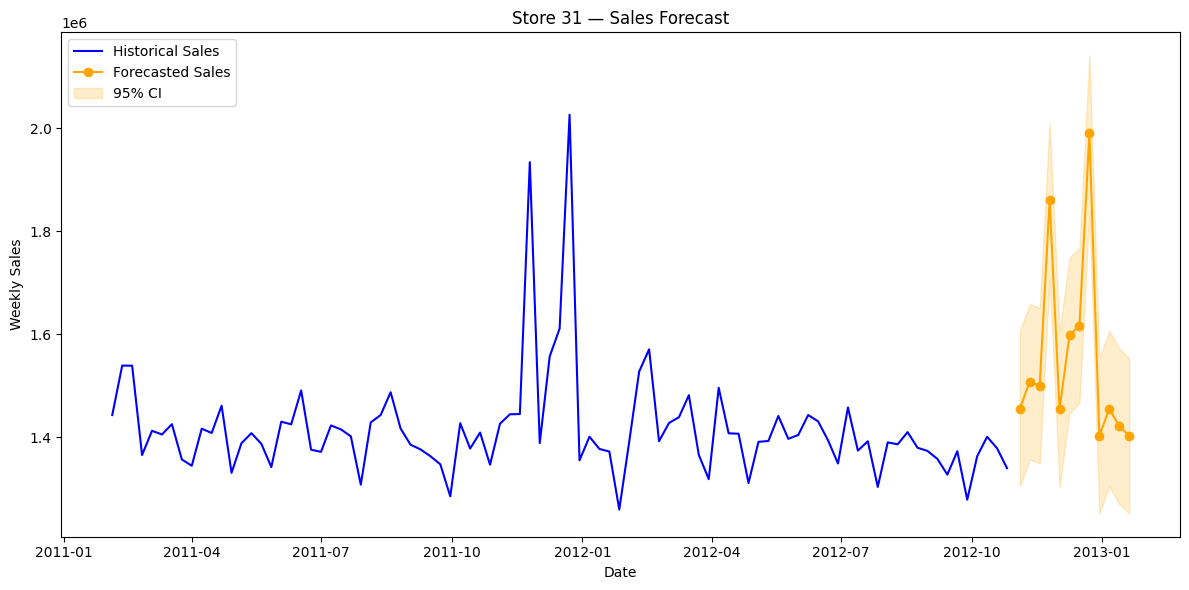

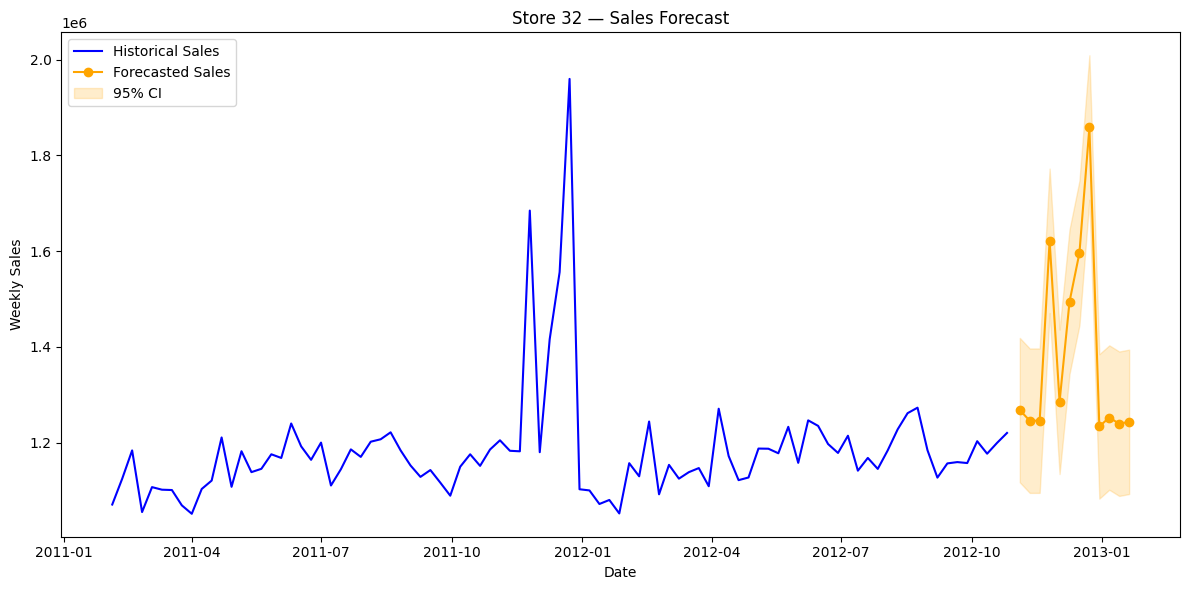

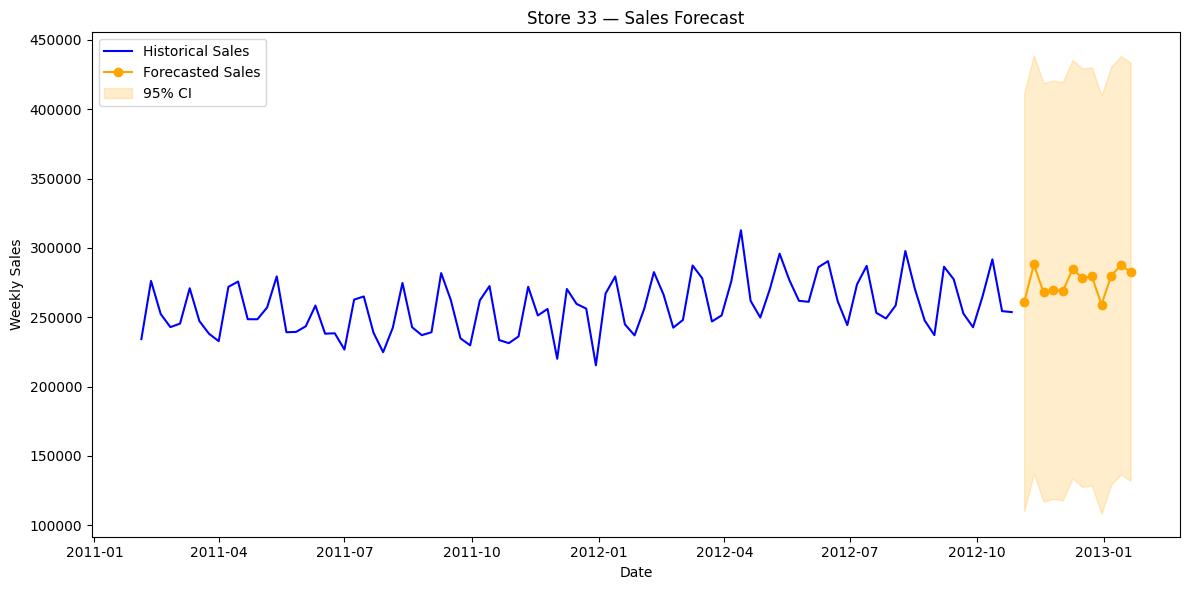

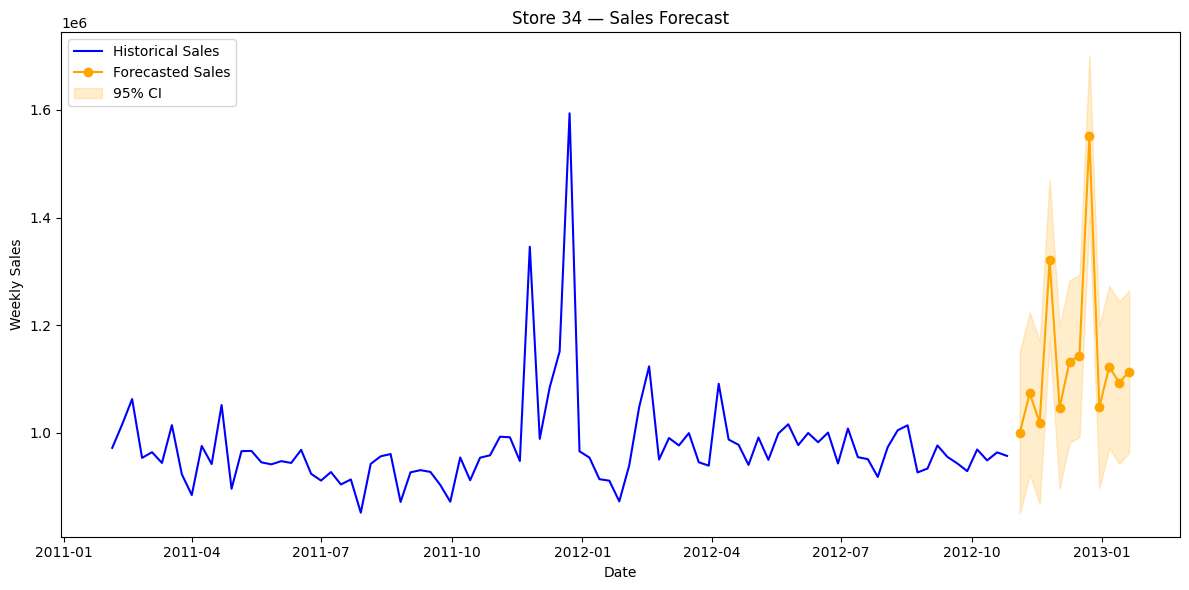

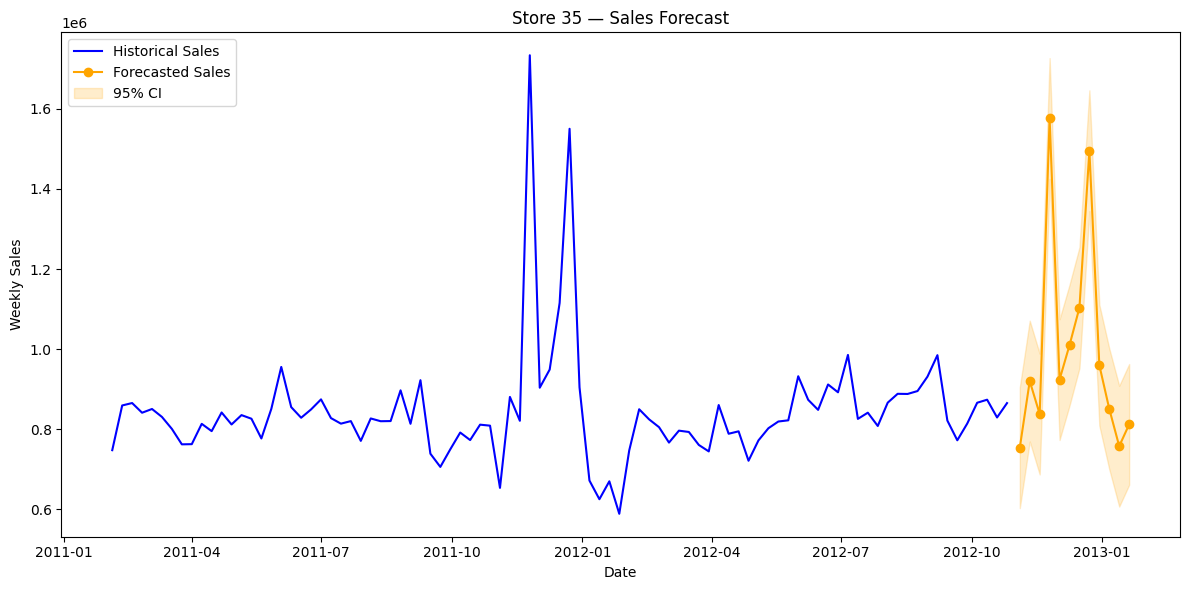

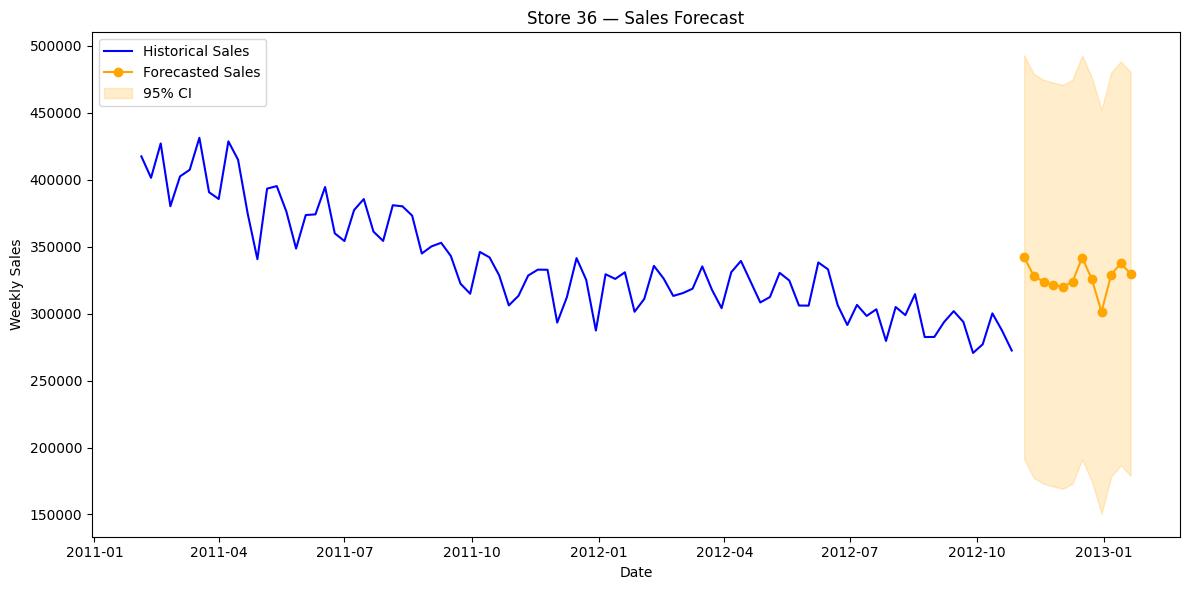

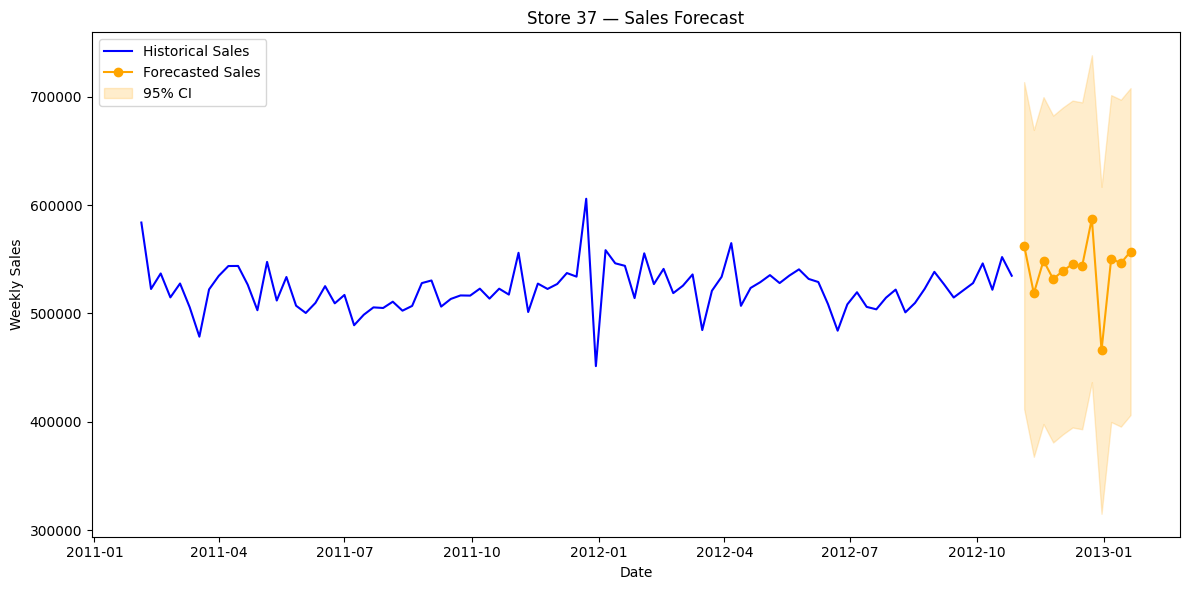

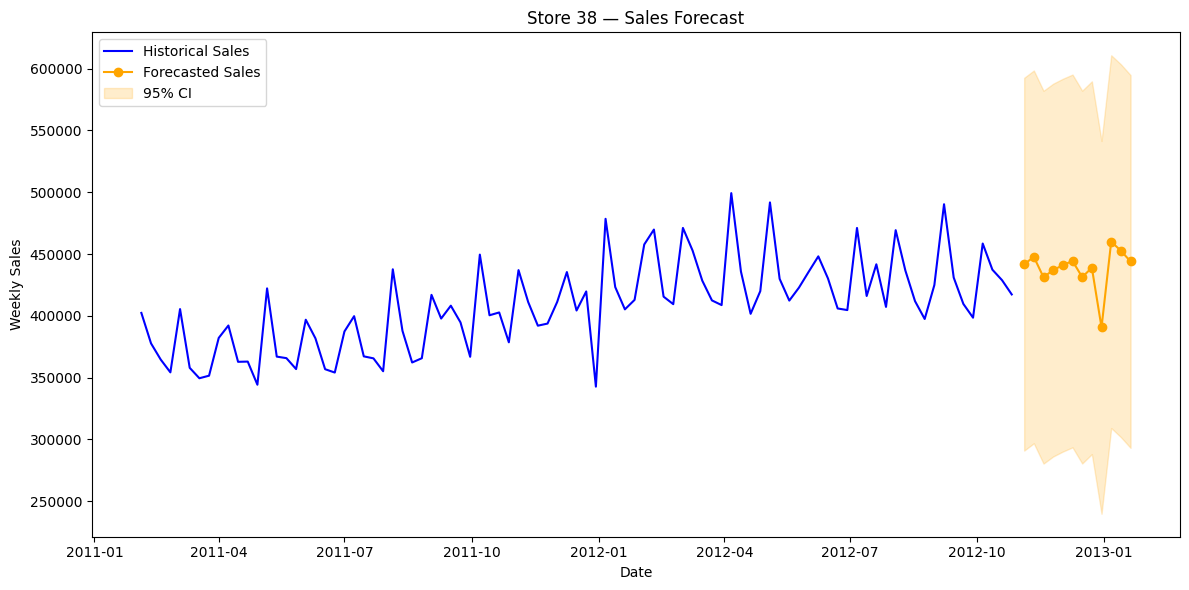

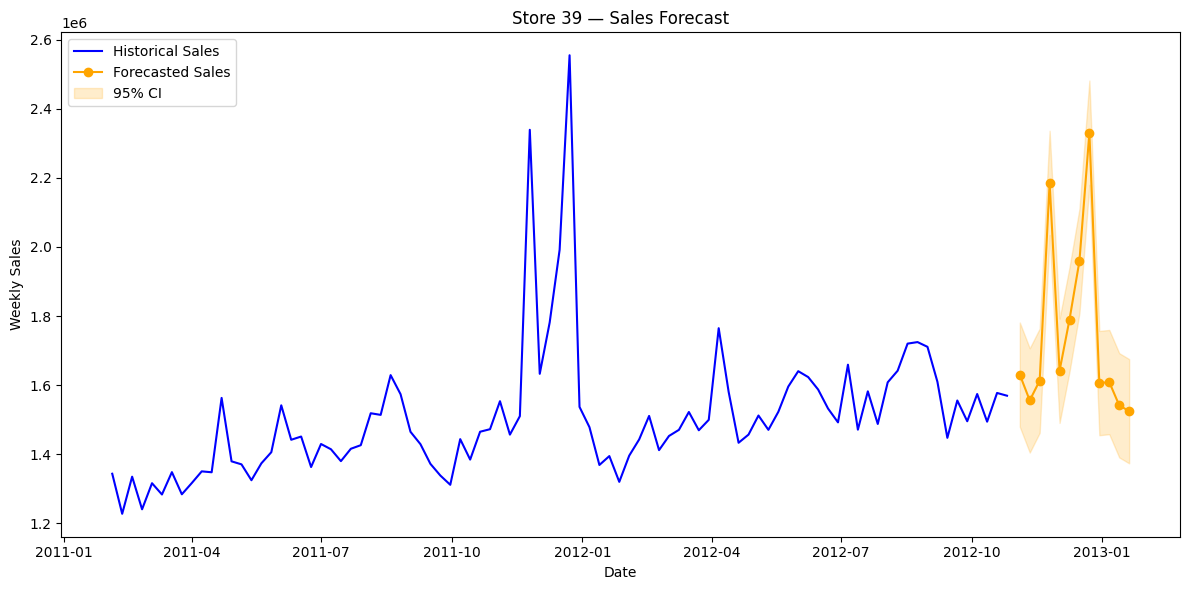

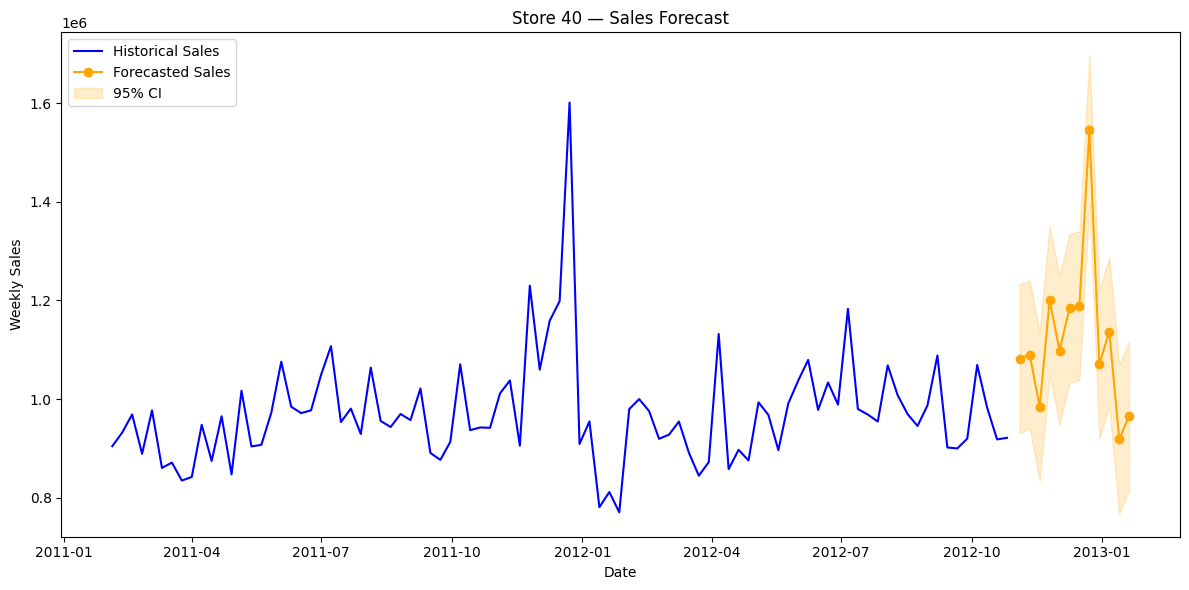

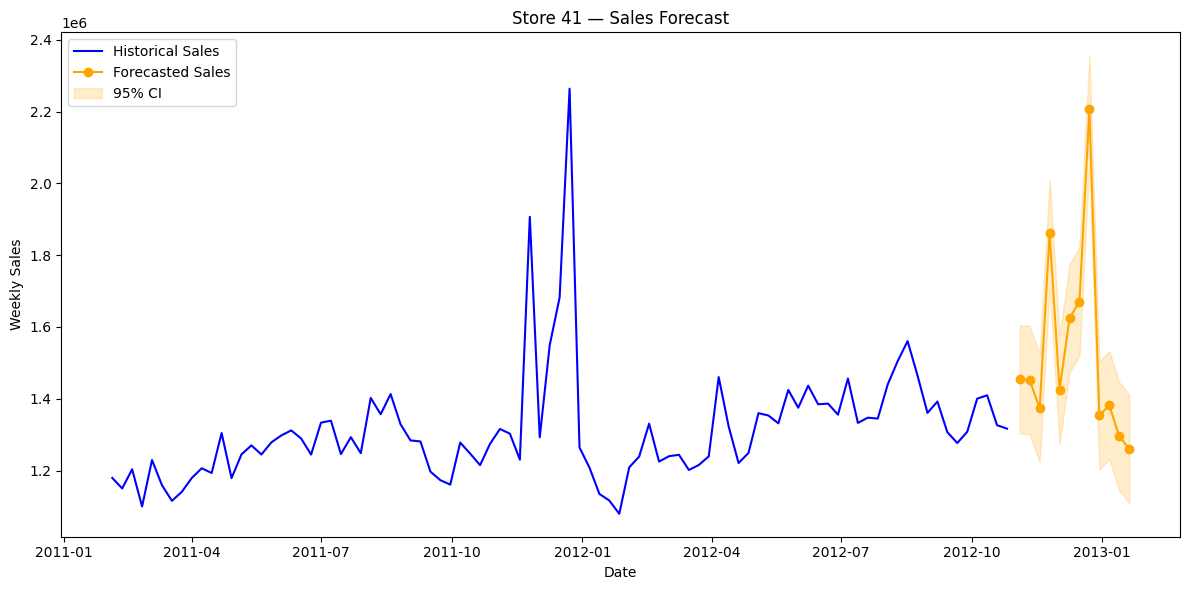

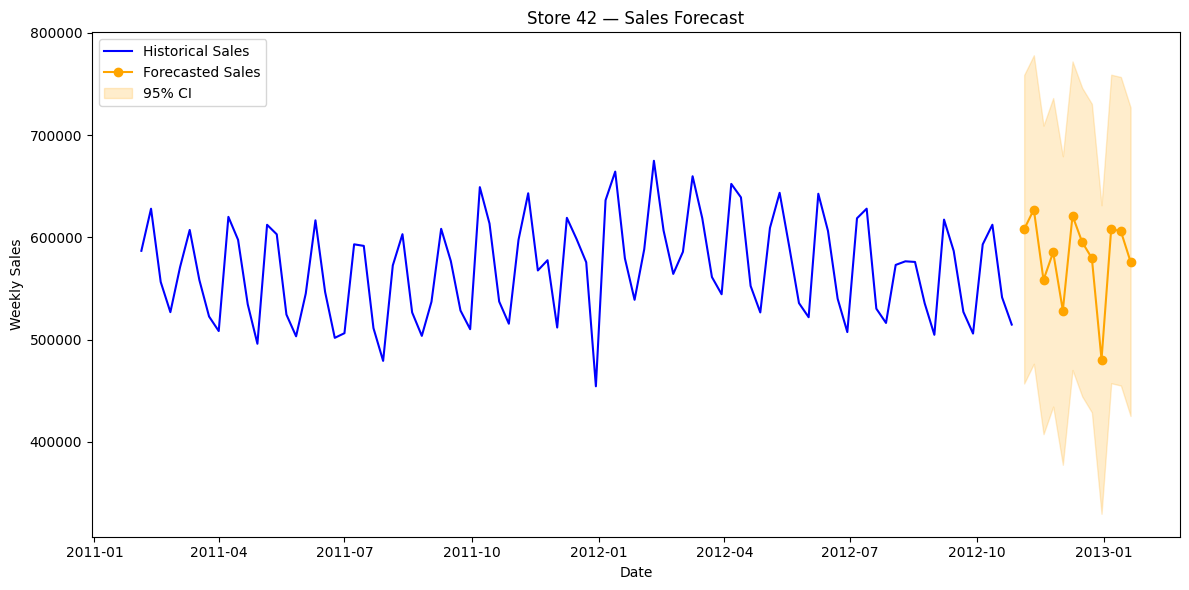

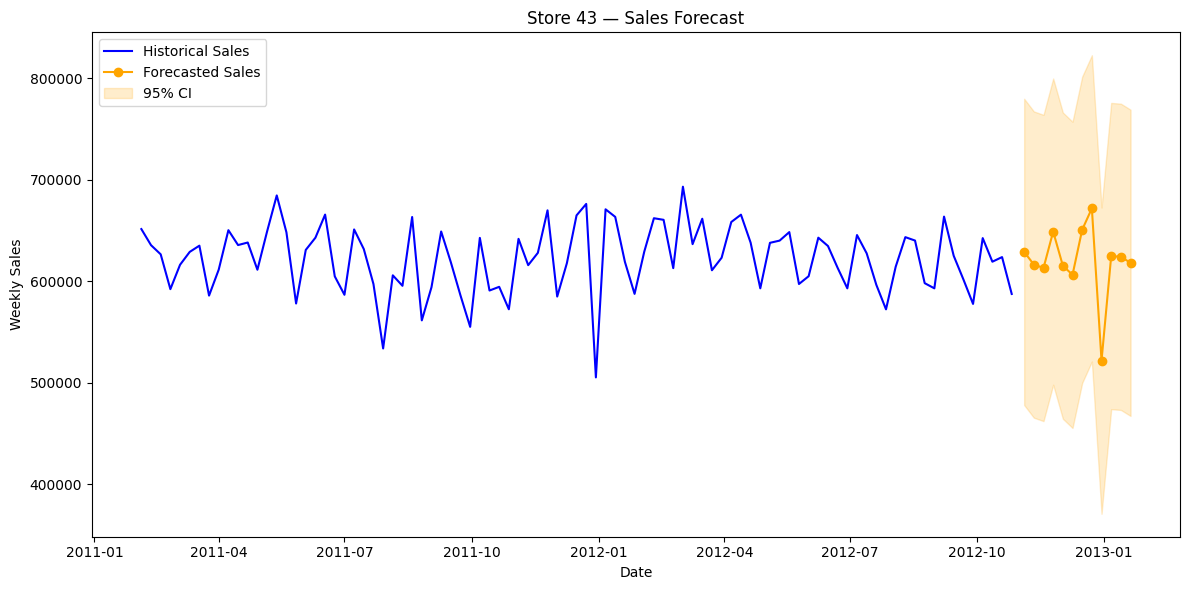

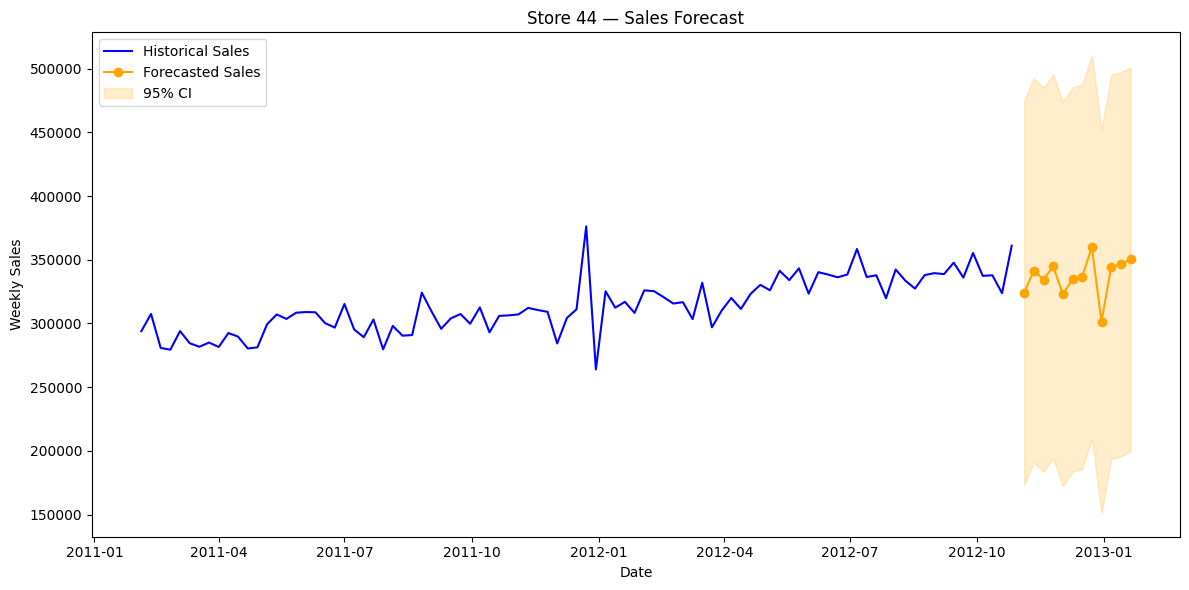

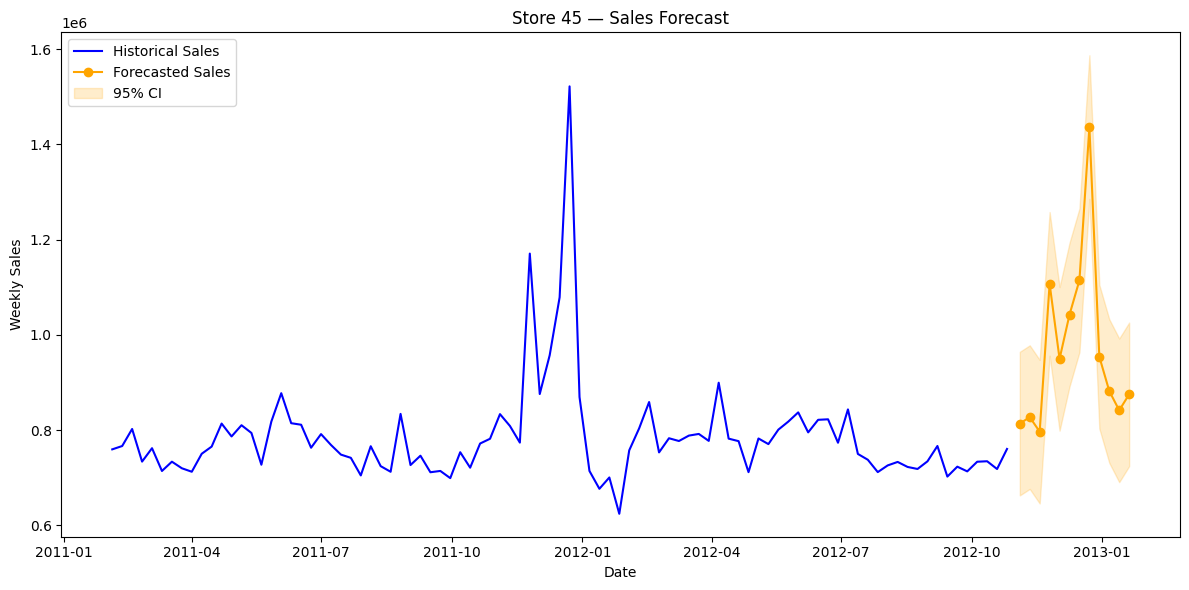

In [23]:
# Assuming your dataframe is called df and has a 'Store' column
existing_stores = df['Store'].unique()  # gets all unique store IDs in the data

for store in sorted(existing_stores):  # sorted just makes the order nicer
    plot_store_forecast(store_id=store)


**Visualization**

Blue line: actual historical sales.

Orange line: 12-week forecasted sales.

Shaded area: 95% confidence interval (uncertainty).

**Interpretation**

You can see how well the forecast aligns with past trends.

The width of the orange shaded area shows forecast confidence.

Sudden spikes or dips in forecast highlight areas of higher uncertainty.

You can compare stores: stores with very wide CI - more volatile sales.

## Example - Interpretation of the visualization for Store 1

**Historical Sales (Blue Line)**

Shows weekly sales from early 2011 to the end of 2012.

The sales have seasonal fluctuations—spikes around holiday periods (e.g., end-of-year) and dips in quieter months.

Overall, sales are mostly stable, ranging roughly between 1.4M and 2.3M.

**Forecasted Sales (Orange Line with Dots)**

Shows the predicted sales for the next 12 weeks after the historical data.

Forecast captures the general trend and some expected fluctuations, reflecting patterns learned from past data.

**95% Confidence Interval (Shaded Area)**

The orange shaded band represents the range where the actual sales are likely to fall with 95% confidence.

Wider intervals (around peaks and troughs) indicate higher uncertainty in forecasts during those periods.

Narrower intervals show more predictable sales.

**Key Observations**

Forecasted sales mostly stay within the historical sales range (1.5M–2.1M).

Some weeks show higher uncertainty, visible as wider shaded bands.

This visualization helps anticipate sales, plan inventory, and identify potential risk periods.

**Business Insight:**

Store 1 has moderate variability, and the forecast suggests sales will remain fairly stable in the coming 12 weeks.

Wide confidence intervals may indicate weeks where demand is harder to predict, and managers may need to adjust stock levels or promotions.

## Insight:

Stable stores → narrow forecast band → predictable sales.

Risky/volatile stores → wide forecast band → plan carefully.

Forecast helps inventory planning, promotion timing, and store-specific strategies. turn this into concise paragraph

## Business Interpretation

The predictive model provides not only point forecasts of weekly sales for each Walmart store but also an estimate of uncertainty around those predictions. This allows managers to distinguish between stable stores and high-risk stores when planning inventory, staffing, and promotions.

**Store Stability & Demand Predictability**

Stores with narrow forecast bands show highly predictable demand. Their past sales patterns are consistent, and external factors such as holidays and economic conditions affect them in a stable way.

For these stores:

Inventory levels can be planned with confidence

Fewer emergency restocks are needed

Staffing schedules can remain steady

These stores are ideal for cost-efficient operations because overstocking and understocking risks are low.

In [24]:
# Attach predictions back to test set
test_results = test.copy()
test_results["Pred"] = pred_test

# Per-store performance
store_perf = (
    test_results
    .groupby("Store")
    .apply(lambda x: pd.Series({
        "RMSE": np.sqrt(mean_squared_error(x["Weekly_Sales"], x["Pred"])),
        "MAPE": mean_absolute_percentage_error(x["Weekly_Sales"], x["Pred"])
    }))
    .reset_index()
    .sort_values("MAPE")
)

store_perf.head()

,Store,RMSE,MAPE
36,37,15736.822480,0.023104
29,30,14742.599296,0.026829
42,43,25474.870327,0.029669
30,31,51397.476168,0.030382
32,33,10895.223805,0.032325


In [25]:
store_perf["Stability"] = np.where(
    store_perf["MAPE"] < 0.10, "Very Stable",
    np.where(store_perf["MAPE"] < 0.20, "Stable",
             "Volatile")
)

store_perf

,Store,RMSE,MAPE,Stability
36,37,15736.822480,0.023104,Very Stable
29,30,14742.599296,0.026829,Very Stable
42,43,25474.870327,0.029669,Very Stable
30,31,51397.476168,0.030382,Very Stable
32,33,10895.223805,0.032325,Very Stable
12,13,100022.471491,0.036459,Very Stable
3,4,103353.466937,0.037045,Very Stable
7,8,46500.024294,0.037811,Very Stable
33,34,48099.008750,0.038967,Very Stable
41,42,30244.378944,0.041403,Very Stable


**Volatile Stores & Risk Management**

Stores with wide forecast bands experience higher uncertainty. This indicates:

*   Irregular customer traffic
*   Strong response to promotions or holidays
*   Sensitivity to economic changes

For these stores:

Managers should keep safety stock

Flexible staffing should be used

Promotions should be carefully timed

These locations need more active management because mistakes in inventory planning can lead to either lost sales or wasted stock.

**Inventory Planning**

The 12-week forecasts allow Walmart to:

Pre-order products based on expected demand

Avoid excess inventory in slow weeks

Increase stock ahead of peak demand


**Promotion & Pricing Strategy**

The model captures seasonality and holiday effects. This means Walmart can:

Schedule promotions during naturally high-demand weeks

Use discounts in low-demand periods to stimulate sales

Avoid unnecessary promotions when demand is already strong

This improves profit margins while still maintaining customer traffic.

**Workforce Planning**

Sales forecasts also indicate how busy stores will be.
Higher predicted sales - more staff needed
Lower predicted sales - fewer staff required

This helps Walmart:

Reduce labor costs

Avoid understaffing during peak weeks

Improve customer service quality

**Strategic Value**

Instead of reacting to last week’s sales, Walmart can plan 3 months ahead using data-driven forecasts

This shifts the company from reactive management to proactive decision-making, improving profitability, efficiency, and customer satisfaction.

## Conclusion

A machine-learning model was developed to predict weekly sales for each Walmart store for the next 12 weeks using past sales patterns, recent trends, seasonal effects, and economic factors such as fuel price, CPI, and unemployment. The data was structured so the model learned only from past weeks through time-series validation, ensuring realistic forecasting without future data leakage.

The model generates forecasts one week at a time, using each prediction to help estimate the next, allowing it to produce a full 12-week sales outlook for every store. These forecasts help distinguish between stable and volatile stores, supporting better inventory control, staffing, and promotion planning. Overall, the system enables Walmart to make proactive, data-driven decisions that reduce risk and improve operational efficiency.